# 2D Material Exfoliation

In this notebook, we provide code to reproduce the results shown in our manuscript on the problem of predicting the exfoliation energy of 2D Materials using compositional and structural features.

In [1]:
import functools
import pickle
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tpot
import sklearn
import optuna
import ase.io
import xgboost
import pymatgen
import xenonpy.descriptor
from tqdm.notebook import tqdm 
import sys, os

sys.path.append("../../../")
import DigitalEcosystem.utils.figures
from DigitalEcosystem.utils.functional import except_with_default_value
from DigitalEcosystem.utils.misc import matminer_descriptors, root_mean_squared_error
from DigitalEcosystem.utils.element_symbols import noble_gases, f_block_elements, synthetic_elements_in_d_block

from IPython.display import Latex

pd.options.mode.chained_assignment = None 
tqdm.pandas()

In [2]:
# Random seeds for reproducibility
RANDOM_SEED = 42
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
# Plot Configuration
plt.rcParams["figure.figsize"] = (15, 15)
plt.rcParams["font.size"] = 32

# Read in the Data

To start, we'll read in the data. Next, we'll convert the exfoliation energies listed in the dataset from eV/atom to eV, to J, then finally from J to J/m^2. This gives us the energy per unit area required to exfoliate a material.

Then, we'll filter out the dataset with the following rules:

1. No elements from the f-block, anything larger than U, or noble gases
2. Decomposition energies must be below 0.5 eV
3. Exfoliation energies must be strictly positive

In [4]:
data = pd.read_pickle('../feature_engineering/full_featurized_data.pkl')

# =========================
# Convert eV/atom to J/m^2
# =========================

# Conversion factors
J_per_eV = 1.60217733e-19
m_per_A = 1e-10

# eV/atom -> eV
data['exfoliation_energy (eV)'] = data['exfoliation_energy_per_atom (eV/atom)'] * data['atoms_object (unitless)'].apply(len)
# eV -> J
data['exfoliation_energy (J)'] = data['exfoliation_energy (eV)'] * J_per_eV

# Get surface area of unit cell (magnitude of the cross-product of the A/B directions). ASE uses the Angstrom as its base unit
data['surface_area (A^2)'] = data['atoms_object (unitless)'].apply(lambda atoms: atoms.get_cell()).apply(lambda cell: np.linalg.norm(np.cross(cell[0], cell[1])))

# A^2 -> m^2
data['surface_area (m^2)'] = data['surface_area (A^2)'] * (m_per_A**2)

# J / m^2
data['exfoliation_energy (J/m^2)'] = data['exfoliation_energy (J)'] / data['surface_area (m^2)']

# ==============
# Data filtering
# ==============
target_column = ["exfoliation_energy (J/m^2)"]

# Drop any missing entries (some exfoliation energies are undefined by 2DMatPedia)
data = data[data[target_column[0]].notna()]

# # Drop anything in the f-block, larger than U, and noble gases
bad_elements = noble_gases + f_block_elements + synthetic_elements_in_d_block
element_mask = data['atoms_object (unitless)'].apply(lambda atoms: all([forbidden not in atoms.get_chemical_symbols() for forbidden in bad_elements]))

# Drop anything that decomposes
decomposition_mask = data['decomposition_energy (eV/atom)'] < 0.5

# Drop things with non-strictly-positive exfoliation energies
exfol_mask = data['exfoliation_energy_per_atom (eV/atom)'] > 0

data = data[element_mask & decomposition_mask & exfol_mask]
data

,2dm_id (unitless),Total Angles (angles),Total Atoms (atoms),Total Bonds (bonds),alkaine_earth (atoms),alkaine_earth-alkaine_earth (bonds),alkaine_earth-alkaine_earth-alkaine_earth (angles),alkaine_earth-chalcogen (bonds),alkaine_earth-chalcogen-alkaine_earth (angles),alkaine_earth-chalcogen-alkaline (angles),...,var:thermal_conductivity,var:vdw_radius,var:vdw_radius_alvarez,var:vdw_radius_mm3,var:vdw_radius_uff,exfoliation_energy (eV),exfoliation_energy (J),surface_area (A^2),surface_area (m^2),exfoliation_energy (J/m^2)
1,2dm-2,0,2,0.0,1.0,NaN,NaN,NaN,NaN,NaN,...,8.000000,854.222222,696.888889,672.222222,1142.420000,0.631936,1.012474e-19,21.248620,2.124862e-19,0.476489
2,2dm-3,54,2,21.0,NaN,NaN,NaN,NaN,NaN,NaN,...,524.295506,64.000000,841.000000,484.000000,243.360000,1.149531,1.841752e-19,49.071633,4.907163e-19,0.375319
5,2dm-6,21,2,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3176.098134,50.000000,392.000000,0.888889,5249.708889,0.254492,4.077409e-20,13.828817,1.382882e-19,0.294849
6,2dm-7,21,2,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,512.000000,22.222222,450.000000,14.222222,4815.075556,0.214891,3.442929e-20,11.022780,1.102278e-19,0.312347
7,2dm-8,21,2,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,566.273422,150.222222,854.222222,10.888889,3237.442222,0.201447,3.227536e-20,8.880537,8.880537e-20,0.363439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5976,2dm-5987,193,3,24.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1202.000000,6.138889,406.250000,110.250000,5625.182222,0.359088,5.753233e-20,14.172602,1.417260e-19,0.405941
6347,2dm-84,36,2,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1288.630506,272.250000,400.000000,144.000000,4102.402500,0.452286,7.246429e-20,10.725896,1.072590e-19,0.675601
6348,2dm-152,54,2,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1277.347600,132.250000,552.250000,25.000000,5263.502500,0.500124,8.012867e-20,11.755506,1.175551e-19,0.681627
6349,2dm-6459,36,2,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1288.630506,272.250000,400.000000,144.000000,4102.402500,0.434485,6.961224e-20,11.475655,1.147566e-19,0.606608


In [5]:
xenonpy_descriptors = [col for col in data.columns if ":" in col]
descriptors = xenonpy_descriptors + matminer_descriptors

# Prepare Data
Next up, we'll perform a train/test split, holding out 10% of the data as a test set.

In [6]:
train, test = sklearn.model_selection.train_test_split(data, test_size=0.1, random_state=RANDOM_SEED)

train_x = np.nan_to_num(train[descriptors].to_numpy())
train_y = np.nan_to_num(train[target_column].to_numpy())

test_x = np.nan_to_num(test[descriptors].to_numpy())
test_y = np.nan_to_num(test[target_column].to_numpy())

In [7]:
def rmse(y_true, y_pred):
    mse = sklearn.metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(abs(mse))
    return rmse

metrics = {
    'MaxError': sklearn.metrics.max_error,
    'MAE': sklearn.metrics.mean_absolute_error,
    'MSE': sklearn.metrics.mean_squared_error,
    'RMSE': root_mean_squared_error,
    'MAPE': sklearn.metrics.mean_absolute_percentage_error,
    'R2': sklearn.metrics.r2_score
}

# XGBoost

XGBoost is a gradient boosting algorithm that uses an ensemble of decision trees. It's a very flexible model that comes with a lot of hyperparameters to tune. To tune them, we'll use Optuna, a Bayesian optimization framework. We'll also use Optuna to choose whether we use Z-score normalization or min/max scaling on the data.

We'll hold out 20% of the data as a validation set, for early-stopping and pruning purposes. We'll train the model to minimize its RMSE on the training set.

In [8]:
current_reg = None
best_reg = None
def keep_best_reg(study, trial):
    global best_reg
    if study.best_trial == trial:
        best_reg = current_reg

objective_train_x_reg, objective_validation_x_reg, objective_train_y_reg, objective_validation_y_reg = sklearn.model_selection.train_test_split(
    np.nan_to_num(train_x), train_y, test_size=0.2, random_state=RANDOM_SEED)

def objective(trial: optuna.Trial):
    global current_reg


    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0, 2),
        'min_split_loss': trial.suggest_float('min_split_loss', 0, 2),
        'max_depth': trial.suggest_int('max_depth', 1, 256),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2)
    }
    
    scalers = {
        "StandardScaler": sklearn.preprocessing.StandardScaler(),
        "MinMaxScaler": sklearn.preprocessing.MinMaxScaler()
    }

    scaler = trial.suggest_categorical('scaler', scalers.keys())

    current_reg = sklearn.pipeline.Pipeline([
        (scaler, scalers[scaler]),
        ("XGB_Regressor", xgboost.sklearn.XGBRegressor(**params,
                                               n_estimators=256,
                                               n_jobs=1,
                                               objective='reg:squarederror',
                                               random_state=RANDOM_SEED),)
    ])

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-rmse')
    current_reg.fit(X=objective_train_x_reg, y=objective_train_y_reg,
                         **{
                            'XGB_Regressor__eval_set': [[objective_validation_x_reg, objective_validation_y_reg]],
                            'XGB_Regressor__eval_metric': 'rmse',
                            'XGB_Regressor__early_stopping_rounds': 50,
                            'XGB_Regressor__callbacks': [pruning_callback],
                            'XGB_Regressor__verbose': False
                         })

    mse = sklearn.metrics.mean_squared_error(
        y_true=objective_validation_y_reg,
        y_pred=current_reg.predict(objective_validation_x_reg),
    )
    rmse = np.sqrt(mse)

    return rmse

reg_study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed = RANDOM_SEED,
        warn_independent_sampling = True,
        consider_endpoints = True
    ),
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=256),
    direction='minimize')

reg_study.optimize(func=objective, n_trials=1000, callbacks=[keep_best_reg])

[I 2021-11-01 07:04:09,686] A new study created in memory with name: no-name-8cd32d64-b942-4c4b-92cc-e2cd53fb604a


KeyboardInterrupt: 

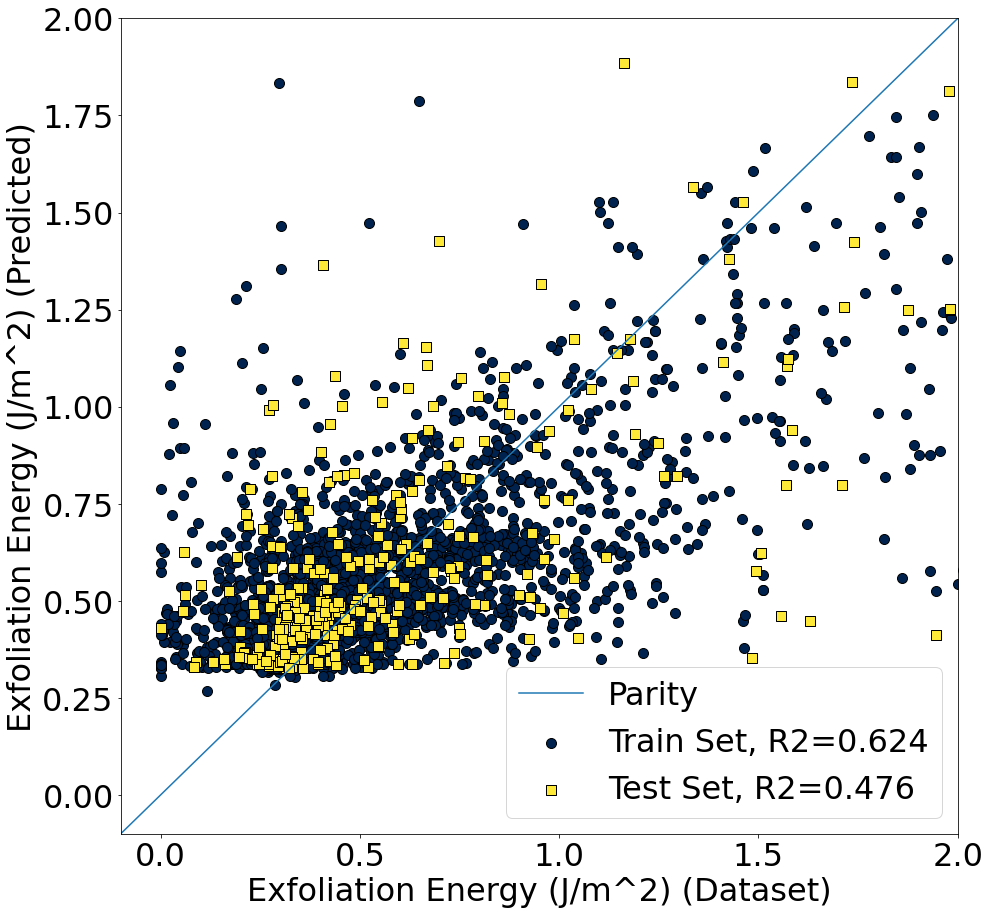

In [187]:
DigitalEcosystem.utils.figures.save_parity_plot_publication_quality(train_y_true = train_y,
                                                                    train_y_pred = best_reg.predict(train_x),
                                                                    test_y_true = test_y,
                                                                    test_y_pred = best_reg.predict(test_x),
                                                                    axis_label = "Exfoliation Energy (J/m^2)",
                                                                    axis_limits=[-0.1,2],
                                                                    filename = "xgboost_2dm_exfoliation_parity.jpeg")

In [13]:
print("Test Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=test_y, y_pred=best_reg.predict(test_x))
    print(key,np.round(value,4))
    
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=train_y, y_pred=best_reg.predict(train_x))
    print(key,np.round(value,4))

Test Set Error Metrics
MaxError 1.6364
MAE 0.229
MSE 0.124
RMSE 0.3522
MAPE 2.7826
R2 0.4755

Training Set Error Metrics
MaxError 7.1063
MAE 0.1955
MSE 0.1202
RMSE 0.3467
MAPE 4.1925
R2 0.624


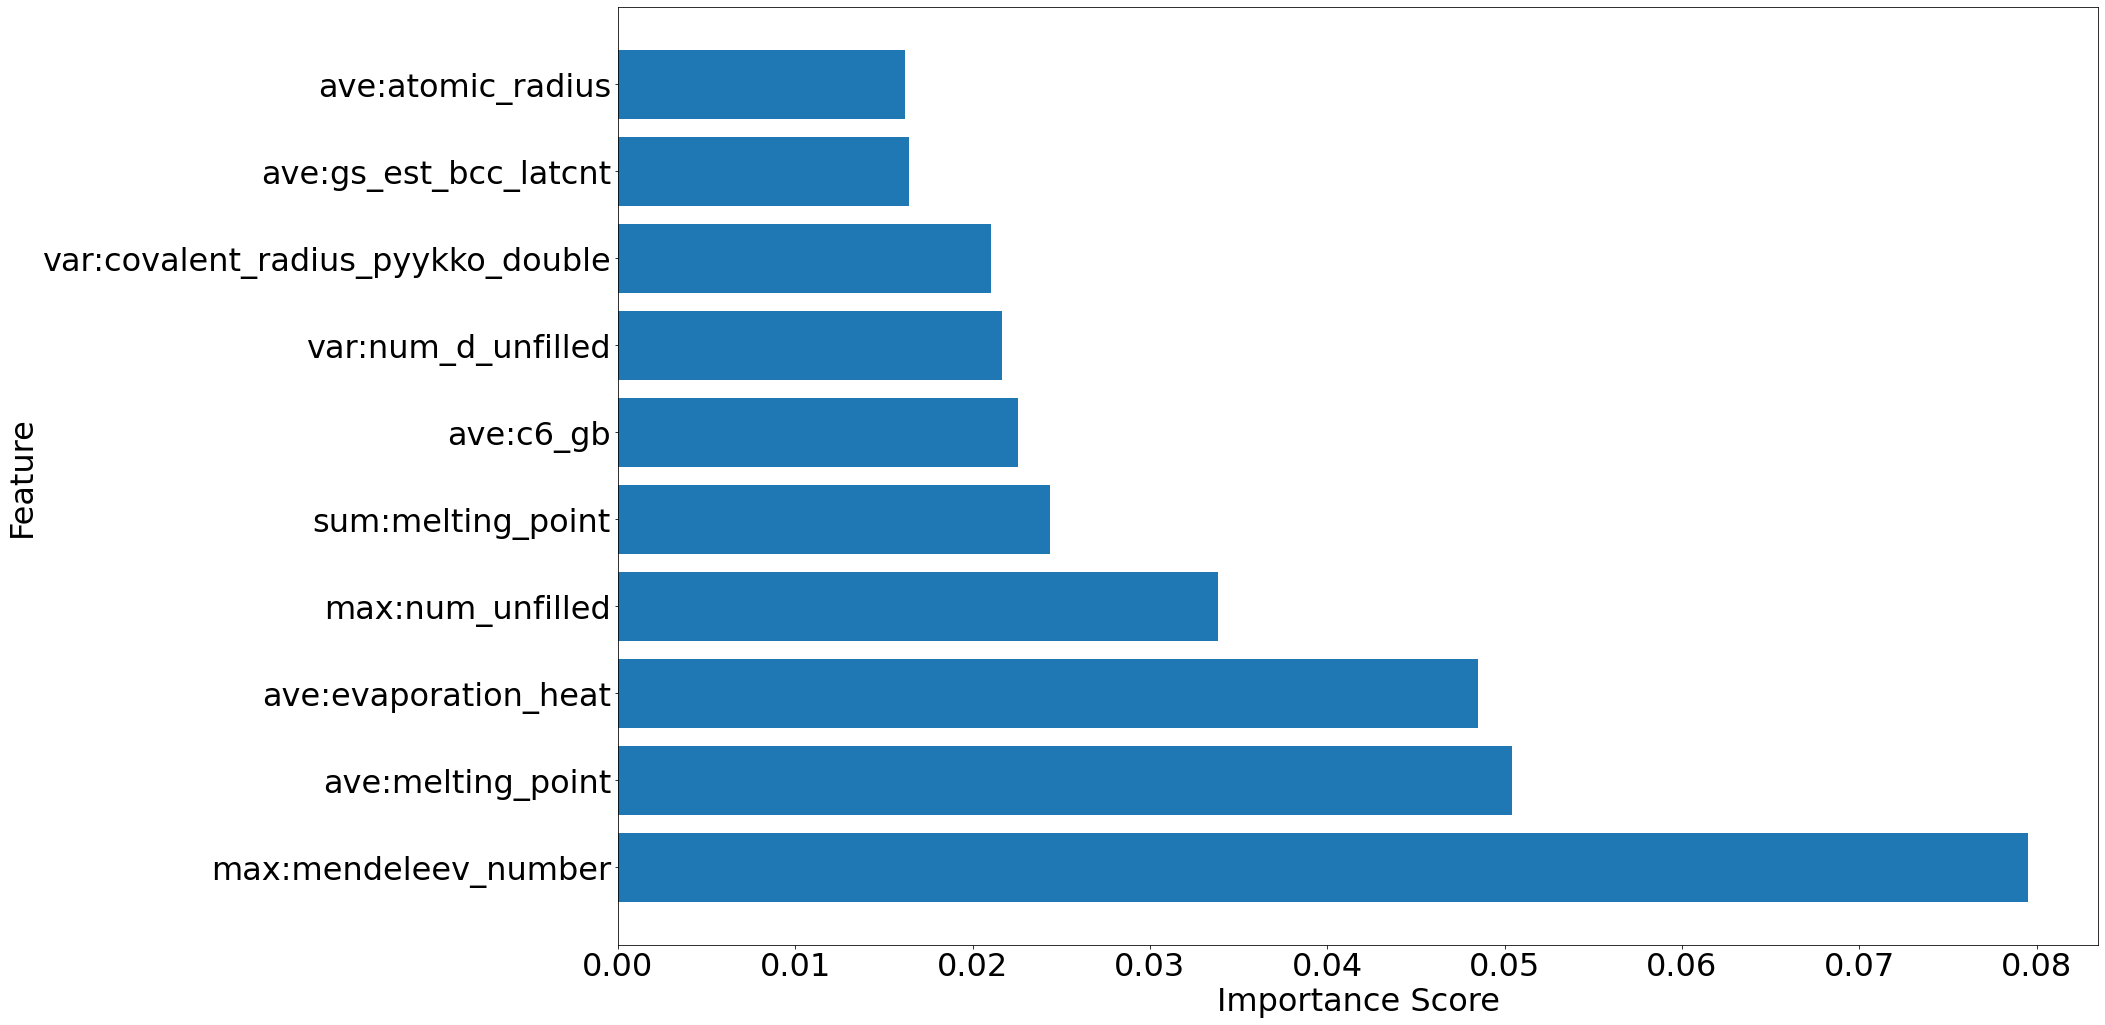

In [144]:
n_importances = 10
importances = list(zip(best_reg[1].feature_importances_, xenonpy_descriptors))

sorted_importances = list(sorted(importances, key=lambda i: -i[0]))

old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (2*old_figsize[0], old_figsize[1])

plt.barh(range(n_importances), [imp[0] for imp in sorted_importances[:n_importances]])
plt.yticks(range(n_importances), [imp[1] for imp in sorted_importances[:n_importances]])
plt.ylabel("Feature") 
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("xgboost_2dm_exfoliation_importances.jpeg")
plt.show()
plt.close()

plt.rcParams["figure.figsize"] = old_figsize

Finally, for some book-keeping purposes, we'll go ahead and save the predictions from the XGBoost model, along with the importance scores from the above plot. Also, we'll go ahead and pickle the XGBoost pipeline.

In [38]:
train_preds = train[target_column]
train_preds['TrainTest Status'] = ['Training Set'] * len(train_preds)
train_preds['Prediction'] = best_reg.predict(train_x)

test_preds = test[target_column]
test_preds['TrainTest Status'] = ['Test Set'] * len(test_preds)
test_preds['Prediction'] = best_reg.predict(test_x)

xgb_predictions = train_preds.append(test_preds)
xgb_predictions.to_csv("xgboost_2dm_exfoliation_predictions.csv")

In [39]:
with open("xgboost_2dm_exfoliation_importances.csv", "w") as outp:
    outp.write("Descriptor,XGB_Importance\n")
    for importance, descriptor in sorted_importances:
        outp.write(f"{descriptor},{importance}\n")

In [49]:
with open("xgboost_pipeline.pkl", "wb") as outp:
    pickle.dump(best_reg, outp)

# TPOT

TPOT is an AutoML solution that uses a genetic algorithm to create an ML pipeline to address a given problem. Here, we'll run a population of 100 models over 10 generations, taking the 10-fold cross-validated RMSE as the fitness metric.

We'll also go ahead and save a parity plot of the TPOT model.

In [14]:
tpot_model = tpot.TPOTRegressor(
    generations=10,
    population_size=100,
    max_eval_time_mins=10 / 60,
    cv=10,
    verbosity=2,
    scoring="neg_root_mean_squared_error",
    config_dict=tpot.config.regressor_config_dict,
    n_jobs=-1,
    random_state=RANDOM_SEED
)

tpot_model.fit(train_x, train_y.ravel())

Optimization Progress:   0%|          | 0/1100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.4548862343076867

Generation 2 - Current best internal CV score: -0.45311909831177377

Generation 3 - Current best internal CV score: -0.45311909831177377

Generation 4 - Current best internal CV score: -0.43237967842004166

Generation 5 - Current best internal CV score: -0.4296431516669987

Generation 6 - Current best internal CV score: -0.41640600188691906

Generation 7 - Current best internal CV score: -0.41640600188691906

Generation 8 - Current best internal CV score: -0.41640600188691906

Generation 9 - Current best internal CV score: -0.41640600188691906

Generation 10 - Current best internal CV score: -0.41596699162461565

Best pipeline: ExtraTreesRegressor(SelectFwe(input_matrix, alpha=0.047), bootstrap=True, max_features=0.25, min_samples_leaf=3, min_samples_split=5, n_estimators=100)


TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                           'sklearn.decomposition.PCA': {'iter

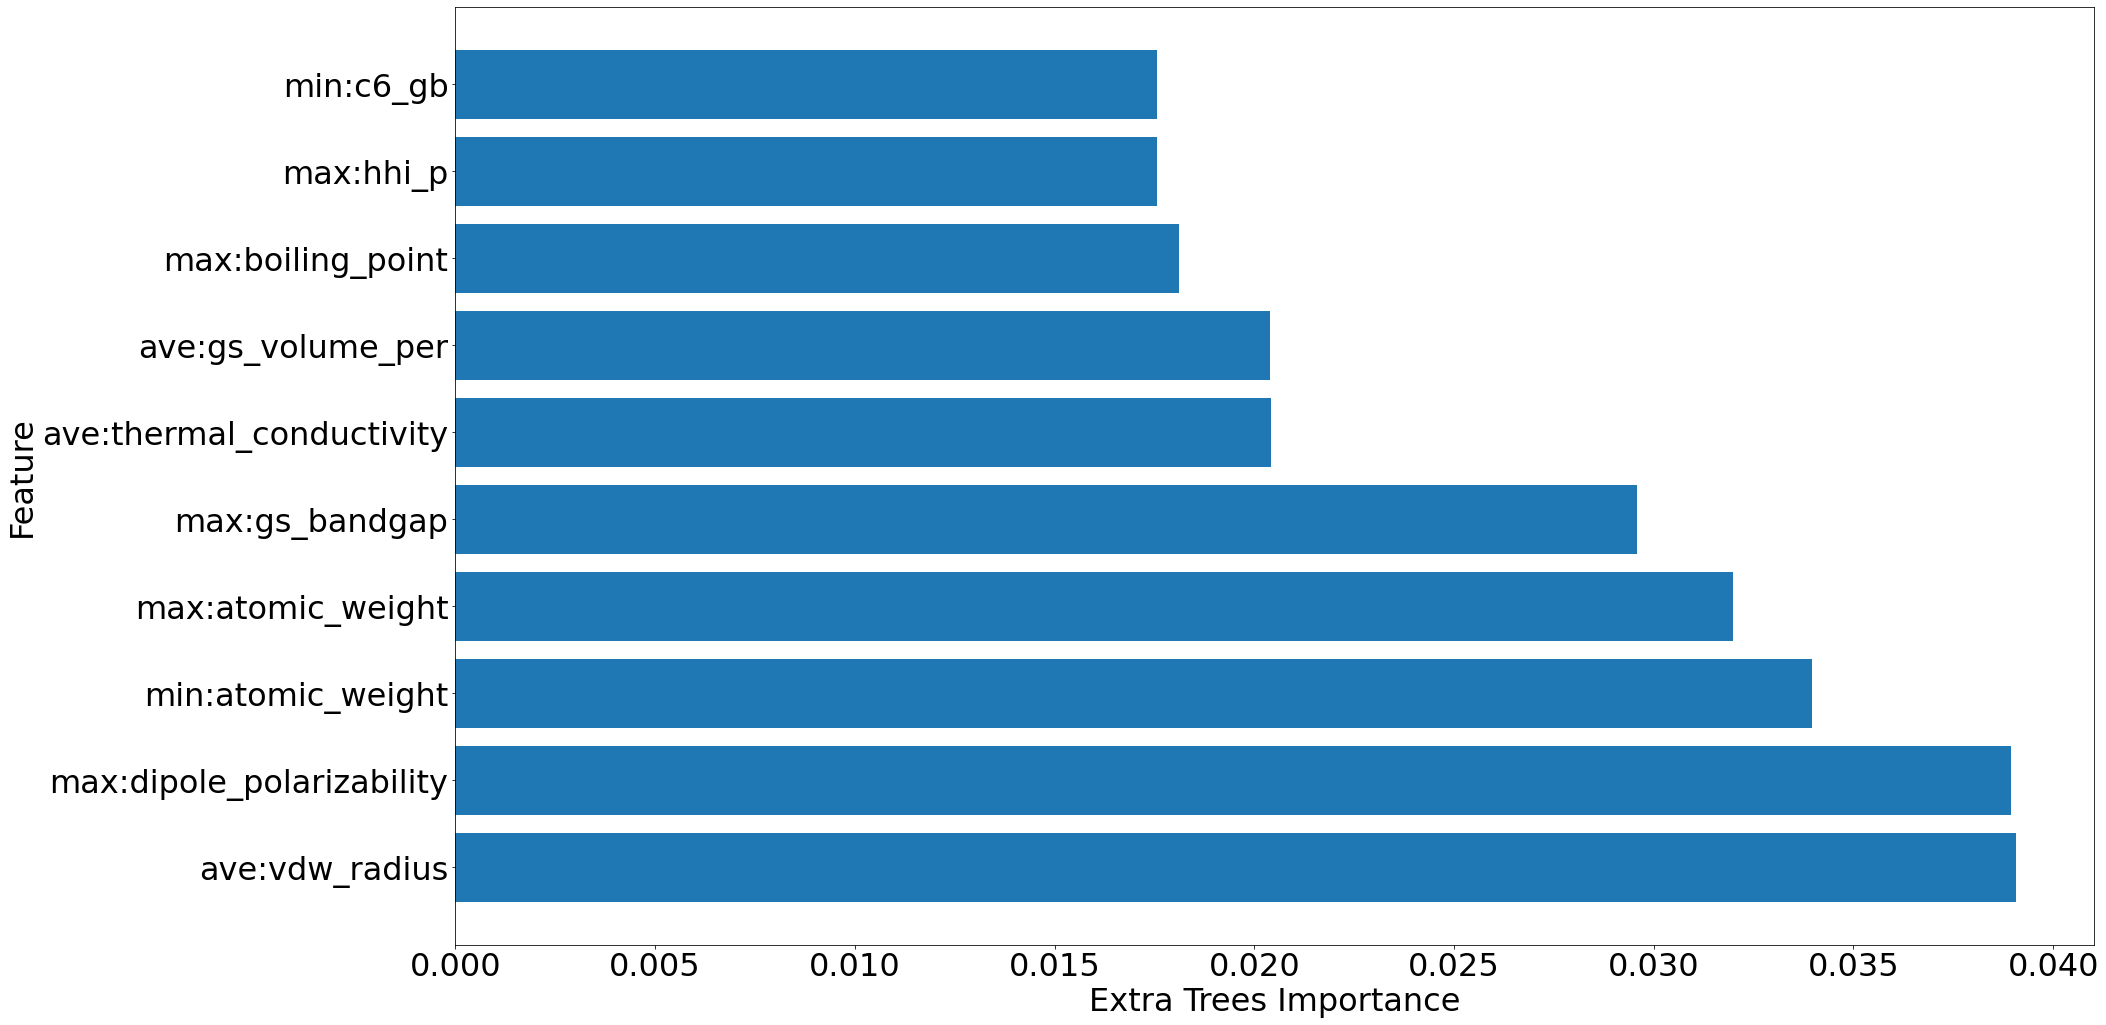

In [143]:
tpot_importances = zip(tpot_model.fitted_pipeline_[1].feature_importances_, descriptors)
sorted_tpot_importances = list(sorted(tpot_importances, key=lambda i: -abs(i[0])))

old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (2*old_figsize[0], old_figsize[1])

plt.barh(range(n_importances), [imp[0] for imp in sorted_tpot_importances[:n_importances]])
plt.yticks(range(n_importances), [imp[1] for imp in sorted_tpot_importances[:n_importances]])
plt.ylabel("Feature")
plt.xlabel("Extra Trees Importance")
plt.tight_layout()
plt.show()
plt.savefig("tpot_perovskite_volume_importances.jpeg")
plt.close()

plt.rcParams["figure.figsize"] = old_figsize

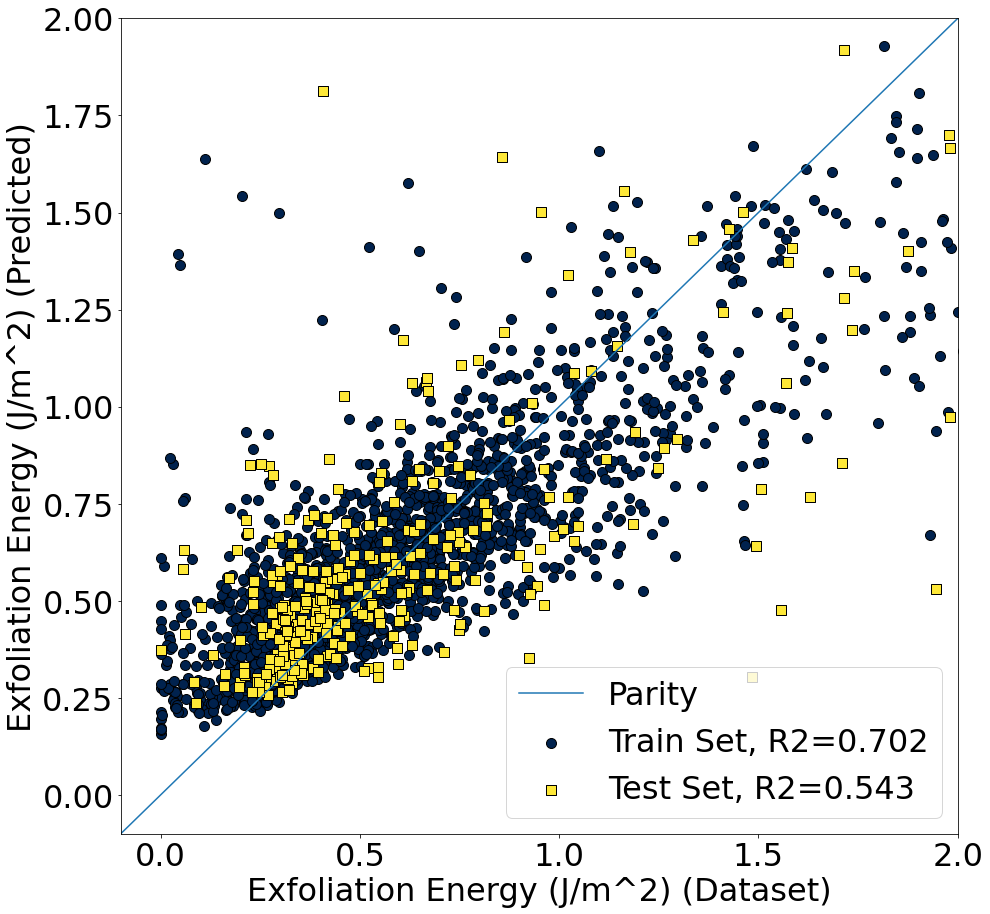

In [188]:
DigitalEcosystem.utils.figures.save_parity_plot_publication_quality(train_y_true = train_y,
                                                                    train_y_pred = tpot_model.predict(train_x),
                                                                    test_y_true = test_y,
                                                                    test_y_pred = tpot_model.predict(test_x),
                                                                    axis_label = "Exfoliation Energy (J/m^2)",
                                                                    axis_limits=[-0.1,2],
                                                                    filename = "tpot_2dm_exfoliation_parity.jpeg")

In [16]:
print("Test Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=test_y, y_pred=tpot_model.predict(test_x))
    print(key,np.round(value,4))
    
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=train_y, y_pred=tpot_model.predict(train_x))
    print(key,np.round(value,4))

Test Set Error Metrics
MaxError 1.8514
MAE 0.2065
MSE 0.1082
RMSE 0.3289
MAPE 2.4315
R2 0.5425

Training Set Error Metrics
MaxError 8.3352
MAE 0.1436
MSE 0.0951
RMSE 0.3085
MAPE 2.934
R2 0.7024


Finally, we'll go ahead and back up those predictions to the disk (this way, we don't need to re-run this again just to get those), and we'll pickle the TPOT model. We'll also have TPOT auto-generate some Python code to re-train itself.

In [51]:
train_preds = train[target_column]
train_preds['TrainTest Status'] = ['Training Set'] * len(train_preds)
train_preds['Prediction'] = tpot_model.predict(train_x)

test_preds = test[target_column]
test_preds['TrainTest Status'] = ['Test Set'] * len(test_preds)
test_preds['Prediction'] = tpot_model.predict(test_x)

tpot_predictions = train_preds.append(test_preds)
tpot_predictions.to_csv("tpot_2dm_bandgap_predictions.csv")

We'll also have TPOT automatically generate some Python code to recreate its model. This will get saved to a file named "tpot_autogenerated_pipeline.py." More detail on what this does can be found on TPOT's documentation here: [Link](http://epistasislab.github.io/tpot/using/).

As another mechanism of saving the model, we'll also pickle it.

In [52]:
tpot_model.export('tpot_autogenerated_pipeline.py')
with open("tpot_pipeline.pkl", "wb") as outp:
    pickle.dump(tpot_model.fitted_pipeline_, outp)

# Roost

[Roost](https://github.com/CompRhys/roost) is a neural network approach to predicting material properties as a function of their composition. Although we only have 144 data-points here, we can at least try for a good model.

Since the model only requires material IDs, the composition, and the property of interest, we'll save a CSV containing those properties.

In [8]:
roost_dir = "./roost"
os.makedirs(roost_dir, exist_ok=True)
roost_data_train = train[['formula'] + target_column]
roost_data_test = test[['formula'] + target_column]

roost_data_train.to_csv(os.path.join(roost_dir, 'roost_train.csv'), index_label='material_id')
roost_data_test.to_csv(os.path.join(roost_dir, 'roost_test.csv'), index_label='material_id')

At this point, Roost models were run. Logs can be found in the Roost directory, along with the resultant predictions.

In [17]:
roost_train_results = pd.read_csv("roost/roost_train_predictions.csv", index_col="material_id")
roost_test_results  = pd.read_csv("roost/roost_test_predictions.csv", index_col="material_id")

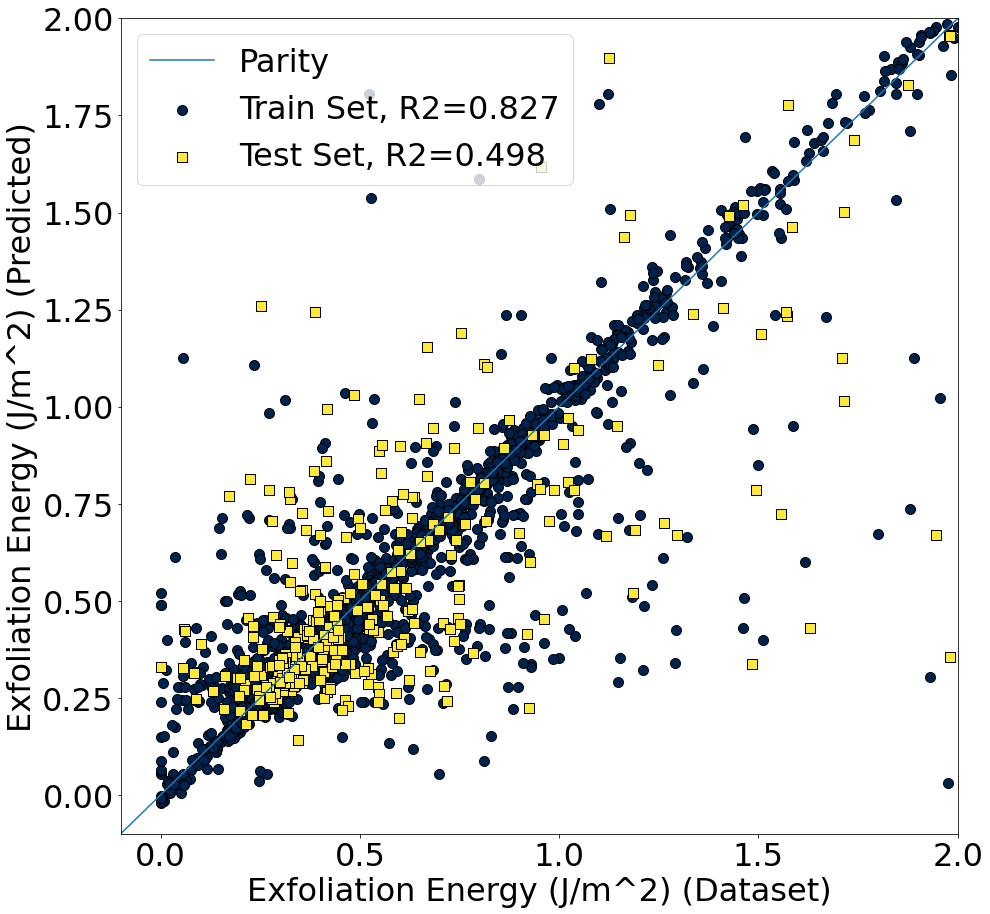

In [189]:
DigitalEcosystem.utils.figures.save_parity_plot_publication_quality(train_y_true = roost_train_results['exfoliation_energy_target'],
                                                                    train_y_pred =  roost_train_results['exfoliation_energy_pred_n0'],
                                                                    test_y_true = roost_test_results['exfoliation_energy_target'],
                                                                    test_y_pred = roost_test_results['exfoliation_energy_pred_n0'],
                                                                    axis_label = "Exfoliation Energy (J/m^2)",
                                                                    axis_limits=[-0.1,2],
                                                                    filename = "roost_2dm_exfoliation_parity.jpeg")

In [22]:
print("Test Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=roost_test_results['exfoliation_energy_target'], y_pred=roost_test_results['exfoliation_energy_pred_n0'])
    print(key,np.round(value,4))
    
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=roost_train_results['exfoliation_energy_target'], y_pred=roost_train_results['exfoliation_energy_pred_n0'])
    print(key,np.round(value,4))

Test Set Error Metrics
MaxError 1.9555
MAE 0.194
MSE 0.1186
RMSE 0.3444
MAPE 2.137
R2 0.4985

Training Set Error Metrics
MaxError 9.6323
MAE 0.0634
MSE 0.0553
RMSE 0.2352
MAPE 1.5148
R2 0.8269


# SISSO

SISSO is a symbolic regression technique focused on creating interpretable machine learning models. 

Due to the exponential computational cost of running a SISSO model as the number of features and rungs increases, we need to restrict the feature space. To do that, we'll use LASSO-based feature selection (essentially we can look at how quickly LASSO extinguishes a variable to get an idea of its importance). 

In [17]:
from sissopp.py_interface import read_csv
from sissopp import FeatureSpace, SISSORegressor

from sissopp.postprocess.feature_space_analysis import get_prevelance_of_primary_features
from sissopp.postprocess.load_models import create_model_csv, load_model

from time import time
from pathlib import Path
import os

In [9]:
# Save CWD
cwd = Path.cwd()

In [10]:
# Rename columns to include units
new_col_names = ["2dm_id (unitless)","Total Angles (n_angles)","Total Atoms (n_atoms)","Total Bonds (n_bonds)","alkaine_earth (n_atoms)","alkaine_earth-alkaine_earth (n_bonds)","alkaine_earth-alkaine_earth-alkaine_earth (n_angles)","alkaine_earth-chalcogen (n_bonds)","alkaine_earth-chalcogen-alkaine_earth (n_angles)","alkaine_earth-chalcogen-alkaline (n_angles)","alkaine_earth-chalcogen-chalcogen (n_angles)","alkaine_earth-chalcogen-early_transition (n_angles)","alkaine_earth-chalcogen-halide (n_angles)","alkaine_earth-chalcogen-late_transition (n_angles)","alkaine_earth-chalcogen-pnictogen (n_angles)","alkaine_earth-chalcogen-tetrel (n_angles)","alkaine_earth-chalcogen-triel (n_angles)","alkaine_earth-early_transition (n_bonds)","alkaine_earth-early_transition-alkaine_earth (n_angles)","alkaine_earth-early_transition-chalcogen (n_angles)","alkaine_earth-early_transition-early_transition (n_angles)","alkaine_earth-early_transition-tetrel (n_angles)","alkaine_earth-f_block (n_bonds)","alkaine_earth-f_block-alkaine_earth (n_angles)","alkaine_earth-f_block-f_block (n_angles)","alkaine_earth-halide (n_bonds)","alkaine_earth-halide-alkaine_earth (n_angles)","alkaine_earth-halide-early_transition (n_angles)","alkaine_earth-halide-tetrel (n_angles)","alkaine_earth-late_transition (n_bonds)","alkaine_earth-late_transition-alkaine_earth (n_angles)","alkaine_earth-late_transition-chalcogen (n_angles)","alkaine_earth-late_transition-late_transition (n_angles)","alkaine_earth-late_transition-tetrel (n_angles)","alkaine_earth-pnictogen (n_bonds)","alkaine_earth-pnictogen-alkaine_earth (n_angles)","alkaine_earth-pnictogen-chalcogen (n_angles)","alkaine_earth-pnictogen-pnictogen (n_angles)","alkaine_earth-pnictogen-tetrel (n_angles)","alkaine_earth-tetrel (n_bonds)","alkaine_earth-tetrel-alkaine_earth (n_angles)","alkaine_earth-tetrel-chalcogen (n_angles)","alkaine_earth-tetrel-tetrel (n_angles)","alkaline (n_atoms)","alkaline-alkaline (n_bonds)","alkaline-alkaline-alkaline (n_angles)","alkaline-alkaline-chalcogen (n_angles)","alkaline-chalcogen (n_bonds)","alkaline-chalcogen-alkaine_earth (n_angles)","alkaline-chalcogen-alkaline (n_angles)","alkaline-chalcogen-chalcogen (n_angles)","alkaline-chalcogen-early_transition (n_angles)","alkaline-chalcogen-f_block (n_angles)","alkaline-chalcogen-halide (n_angles)","alkaline-chalcogen-late_transition (n_angles)","alkaline-chalcogen-pnictogen (n_angles)","alkaline-chalcogen-tetrel (n_angles)","alkaline-early_transition (n_bonds)","alkaline-early_transition-alkaline (n_angles)","alkaline-early_transition-chalcogen (n_angles)","alkaline-early_transition-early_transition (n_angles)","alkaline-early_transition-halide (n_angles)","alkaline-f_block (n_bonds)","alkaline-f_block-alkaline (n_angles)","alkaline-f_block-halide (n_angles)","alkaline-halide (n_bonds)","alkaline-halide-early_transition (n_angles)","alkaline-halide-late_transition (n_angles)","alkaline-late_transition (n_bonds)","alkaline-late_transition-alkaline (n_angles)","alkaline-late_transition-chalcogen (n_angles)","alkaline-late_transition-halide (n_angles)","alkaline-late_transition-late_transition (n_angles)","alkaline-late_transition-pnictogen (n_angles)","alkaline-pnictogen (n_bonds)","alkaline-pnictogen-alkaine_earth (n_angles)","alkaline-pnictogen-alkaline (n_angles)","alkaline-pnictogen-chalcogen (n_angles)","alkaline-pnictogen-tetrel (n_angles)","alkaline-tetrel (n_bonds)","alkaline-tetrel-alkaline (n_angles)","alkaline-tetrel-chalcogen (n_angles)","alkaline-tetrel-tetrel (n_angles)","alkaline-triel (n_bonds)","alkaline-triel-alkaline (n_angles)","alkaline-triel-triel (n_angles)","atoms_object (unitless)","ave:Polarizability (AA_polar)","ave:atomic_number","ave:atomic_radius (pm)","ave:atomic_radius_rahm (pm)","ave:atomic_volume (cm^3 / mol)","ave:atomic_weight (Da)","ave:boiling_point (K)","ave:bulk_modulus (GPa)","ave:c6_gb (Eh / a0^6)","ave:covalent_radius_cordero (pm)","ave:covalent_radius_pyykko (pm)","ave:covalent_radius_pyykko_double (pm)","ave:covalent_radius_pyykko_triple (pm)","ave:covalent_radius_slater (pm)","ave:density (g / cm^3)","ave:dipole_polarizability (AA_polar^3)","ave:electron_affinity (eV)","ave:electron_negativity (Pauling)","ave:en_allen (eV)","ave:en_ghosh (ghosh)","ave:en_pauling (Pauling)","ave:evaporation_heat (KJ / mol)","ave:first_ion_en (eV)","ave:fusion_enthalpy (KJ / mol)","ave:gs_bandgap (eV)","ave:gs_energy (eV)","ave:gs_est_bcc_latcnt (AA)","ave:gs_est_fcc_latcnt (AA)","ave:gs_mag_moment (mu_B)","ave:gs_volume_per (cm^3 / mol)","ave:heat_capacity_mass (J / g / K)","ave:heat_capacity_molar (J / mol / K)","ave:heat_of_formation (KJ / mol)","ave:hhi_p","ave:hhi_r","ave:icsd_volume (cm^3 / mol)","ave:lattice_constant (AA)","ave:melting_point (K)","ave:mendeleev_number","ave:molar_volume (cm^3)","ave:num_d_unfilled","ave:num_d_valence","ave:num_f_unfilled","ave:num_f_valence","ave:num_p_unfilled","ave:num_p_valence","ave:num_s_unfilled","ave:num_s_valence","ave:num_unfilled","ave:num_valance","ave:period","ave:sound_velocity (m / s)","ave:specific_heat (J / g / K)","ave:thermal_conductivity (W / m / K)","ave:vdw_radius (pm)","ave:vdw_radius_alvarez (pm)","ave:vdw_radius_mm3 (pm)","ave:vdw_radius_uff (pm)","average_cn","bandgap (eV)","bond_angle_average (rad)","bond_length_average (AA)","chalcogen (n_atoms)","chalcogen-alkaine_earth-chalcogen (n_angles)","chalcogen-alkaline-chalcogen (n_angles)","chalcogen-chalcogen (n_bonds)","chalcogen-chalcogen-alkaline (n_angles)","chalcogen-chalcogen-chalcogen (n_angles)","chalcogen-chalcogen-early_transition (n_angles)","chalcogen-chalcogen-halide (n_angles)","chalcogen-chalcogen-late_transition (n_angles)","chalcogen-chalcogen-pnictogen (n_angles)","chalcogen-chalcogen-tetrel (n_angles)","chalcogen-early_transition (n_bonds)","chalcogen-early_transition-chalcogen (n_angles)","chalcogen-early_transition-early_transition (n_angles)","chalcogen-early_transition-halide (n_angles)","chalcogen-early_transition-late_transition (n_angles)","chalcogen-early_transition-pnictogen (n_angles)","chalcogen-f_block (n_bonds)","chalcogen-f_block-chalcogen (n_angles)","chalcogen-f_block-halide (n_angles)","chalcogen-f_block-pnictogen (n_angles)","chalcogen-halide (n_bonds)","chalcogen-halide-chalcogen (n_angles)","chalcogen-halide-early_transition (n_angles)","chalcogen-halide-halide (n_angles)","chalcogen-late_transition (n_bonds)","chalcogen-late_transition-chalcogen (n_angles)","chalcogen-late_transition-early_transition (n_angles)","chalcogen-late_transition-halide (n_angles)","chalcogen-late_transition-late_transition (n_angles)","chalcogen-late_transition-pnictogen (n_angles)","chalcogen-late_transition-tetrel (n_angles)","chalcogen-noble_gas (n_bonds)","chalcogen-noble_gas-chalcogen (n_angles)","chalcogen-noble_gas-halide (n_angles)","chalcogen-pnictogen (n_bonds)","chalcogen-pnictogen-chalcogen (n_angles)","chalcogen-pnictogen-halide (n_angles)","chalcogen-pnictogen-pnictogen (n_angles)","chalcogen-post_uranium (n_bonds)","chalcogen-post_uranium-chalcogen (n_angles)","chalcogen-post_uranium-halide (n_angles)","chalcogen-tetrel (n_bonds)","chalcogen-tetrel-chalcogen (n_angles)","chalcogen-tetrel-halide (n_angles)","chalcogen-tetrel-pnictogen (n_angles)","chalcogen-triel (n_bonds)","chalcogen-triel-chalcogen (n_angles)","chalcogen-triel-halide (n_angles)","decomposition_energy (eV/atom)","discovery_process (Unitless)","early_transition (n_atoms)","early_transition-alkaine_earth-chalcogen (n_angles)","early_transition-alkaine_earth-early_transition (n_angles)","early_transition-alkaline-chalcogen (n_angles)","early_transition-alkaline-early_transition (n_angles)","early_transition-chalcogen-alkaine_earth (n_angles)","early_transition-chalcogen-alkaline (n_angles)","early_transition-chalcogen-chalcogen (n_angles)","early_transition-chalcogen-early_transition (n_angles)","early_transition-chalcogen-halide (n_angles)","early_transition-chalcogen-late_transition (n_angles)","early_transition-chalcogen-pnictogen (n_angles)","early_transition-chalcogen-tetrel (n_angles)","early_transition-chalcogen-triel (n_angles)","early_transition-early_transition (n_bonds)","early_transition-early_transition-alkaine_earth (n_angles)","early_transition-early_transition-alkaline (n_angles)","early_transition-early_transition-chalcogen (n_angles)","early_transition-early_transition-early_transition (n_angles)","early_transition-early_transition-halide (n_angles)","early_transition-early_transition-late_transition (n_angles)","early_transition-early_transition-pnictogen (n_angles)","early_transition-early_transition-tetrel (n_angles)","early_transition-early_transition-triel (n_angles)","early_transition-f_block (n_bonds)","early_transition-f_block-chalcogen (n_angles)","early_transition-f_block-early_transition (n_angles)","early_transition-f_block-pnictogen (n_angles)","early_transition-halide (n_bonds)","early_transition-halide-chalcogen (n_angles)","early_transition-halide-early_transition (n_angles)","early_transition-halide-halide (n_angles)","early_transition-halide-late_transition (n_angles)","early_transition-halide-pnictogen (n_angles)","early_transition-halide-tetrel (n_angles)","early_transition-late_transition (n_bonds)","early_transition-late_transition-chalcogen (n_angles)","early_transition-late_transition-early_transition (n_angles)","early_transition-late_transition-halide (n_angles)","early_transition-late_transition-late_transition (n_angles)","early_transition-late_transition-pnictogen (n_angles)","early_transition-late_transition-tetrel (n_angles)","early_transition-late_transition-triel (n_angles)","early_transition-pnictogen (n_bonds)","early_transition-pnictogen-alkaline (n_angles)","early_transition-pnictogen-chalcogen (n_angles)","early_transition-pnictogen-early_transition (n_angles)","early_transition-pnictogen-halide (n_angles)","early_transition-pnictogen-pnictogen (n_angles)","early_transition-tetrel (n_bonds)","early_transition-tetrel-chalcogen (n_angles)","early_transition-tetrel-early_transition (n_angles)","early_transition-tetrel-late_transition (n_angles)","early_transition-tetrel-tetrel (n_angles)","early_transition-tetrel-triel (n_angles)","early_transition-triel (n_bonds)","early_transition-triel-chalcogen (n_angles)","early_transition-triel-early_transition (n_angles)","early_transition-triel-late_transition (n_angles)","early_transition-triel-tetrel (n_angles)","early_transition-triel-triel (n_angles)","energy_per_atom (eV)","energy_vdw_per_atom (eV/atom)","ewald_energy_per_atom (eV / atom)","exfoliation_energy_per_atom (eV/atom)","f_block (n_atoms)","f_block-alkaine_earth-f_block (n_angles)","f_block-alkaline-f_block (n_angles)","f_block-chalcogen-alkaline (n_angles)","f_block-chalcogen-chalcogen (n_angles)","f_block-chalcogen-early_transition (n_angles)","f_block-chalcogen-f_block (n_angles)","f_block-chalcogen-halide (n_angles)","f_block-chalcogen-late_transition (n_angles)","f_block-chalcogen-pnictogen (n_angles)","f_block-chalcogen-tetrel (n_angles)","f_block-chalcogen-triel (n_angles)","f_block-early_transition-chalcogen (n_angles)","f_block-early_transition-early_transition (n_angles)","f_block-early_transition-f_block (n_angles)","f_block-early_transition-pnictogen (n_angles)","f_block-f_block (n_bonds)","f_block-f_block-alkaine_earth (n_angles)","f_block-f_block-alkaline (n_angles)","f_block-f_block-chalcogen (n_angles)","f_block-f_block-early_transition (n_angles)","f_block-f_block-f_block (n_angles)","f_block-f_block-halide (n_angles)","f_block-f_block-late_transition (n_angles)","f_block-f_block-pnictogen (n_angles)","f_block-f_block-tetrel (n_angles)","f_block-f_block-triel (n_angles)","f_block-halide (n_bonds)","f_block-halide-alkaine_earth (n_angles)","f_block-halide-chalcogen (n_angles)","f_block-halide-f_block (n_angles)","f_block-halide-halide (n_angles)","f_block-halide-tetrel (n_angles)","f_block-halide-triel (n_angles)","f_block-late_transition (n_bonds)","f_block-late_transition-alkaine_earth (n_angles)","f_block-late_transition-chalcogen (n_angles)","f_block-late_transition-f_block (n_angles)","f_block-late_transition-late_transition (n_angles)","f_block-late_transition-pnictogen (n_angles)","f_block-late_transition-tetrel (n_angles)","f_block-late_transition-triel (n_angles)","f_block-pnictogen (n_bonds)","f_block-pnictogen-chalcogen (n_angles)","f_block-pnictogen-early_transition (n_angles)","f_block-pnictogen-f_block (n_angles)","f_block-pnictogen-late_transition (n_angles)","f_block-pnictogen-pnictogen (n_angles)","f_block-tetrel (n_bonds)","f_block-tetrel-chalcogen (n_angles)","f_block-tetrel-f_block (n_angles)","f_block-tetrel-late_transition (n_angles)","f_block-tetrel-tetrel (n_angles)","f_block-tetrel-triel (n_angles)","f_block-triel (n_bonds)","f_block-triel-f_block (n_angles)","f_block-triel-late_transition (n_angles)","f_block-triel-tetrel (n_angles)","f_block-triel-triel (n_angles)","formula","global_instability (instable)","halide (n_atoms)","halide-alkaine_earth-chalcogen (n_angles)","halide-alkaine_earth-halide (n_angles)","halide-alkaline-halide (n_angles)","halide-chalcogen-chalcogen (n_angles)","halide-chalcogen-halide (n_angles)","halide-early_transition-chalcogen (n_angles)","halide-early_transition-halide (n_angles)","halide-early_transition-pnictogen (n_angles)","halide-f_block-chalcogen (n_angles)","halide-f_block-halide (n_angles)","halide-f_block-pnictogen (n_angles)","halide-halide (n_bonds)","halide-halide-chalcogen (n_angles)","halide-halide-halide (n_angles)","halide-halide-pnictogen (n_angles)","halide-late_transition (n_bonds)","halide-late_transition-chalcogen (n_angles)","halide-late_transition-halide (n_angles)","halide-late_transition-pnictogen (n_angles)","halide-noble_gas (n_bonds)","halide-noble_gas-halide (n_angles)","halide-pnictogen (n_bonds)","halide-pnictogen-chalcogen (n_angles)","halide-pnictogen-halide (n_angles)","halide-post_uranium (n_bonds)","halide-post_uranium-chalcogen (n_angles)","halide-post_uranium-halide (n_angles)","halide-tetrel (n_bonds)","halide-tetrel-chalcogen (n_angles)","halide-tetrel-halide (n_angles)","halide-triel (n_bonds)","halide-triel-chalcogen (n_angles)","halide-triel-halide (n_angles)","is_bandgap_direct (unitless)","is_hubbard (unitless)","is_metal (unitless)","late_transition (n_atoms)","late_transition-alkaine_earth-chalcogen (n_angles)","late_transition-alkaine_earth-late_transition (n_angles)","late_transition-alkaline-chalcogen (n_angles)","late_transition-alkaline-halide (n_angles)","late_transition-alkaline-late_transition (n_angles)","late_transition-alkaline-triel (n_angles)","late_transition-chalcogen-alkaline (n_angles)","late_transition-chalcogen-chalcogen (n_angles)","late_transition-chalcogen-early_transition (n_angles)","late_transition-chalcogen-halide (n_angles)","late_transition-chalcogen-late_transition (n_angles)","late_transition-chalcogen-pnictogen (n_angles)","late_transition-chalcogen-tetrel (n_angles)","late_transition-chalcogen-triel (n_angles)","late_transition-early_transition-chalcogen (n_angles)","late_transition-early_transition-early_transition (n_angles)","late_transition-early_transition-halide (n_angles)","late_transition-early_transition-late_transition (n_angles)","late_transition-early_transition-pnictogen (n_angles)","late_transition-early_transition-tetrel (n_angles)","late_transition-f_block-chalcogen (n_angles)","late_transition-f_block-late_transition (n_angles)","late_transition-f_block-pnictogen (n_angles)","late_transition-f_block-tetrel (n_angles)","late_transition-halide-chalcogen (n_angles)","late_transition-halide-early_transition (n_angles)","late_transition-halide-late_transition (n_angles)","late_transition-halide-noble_gas (n_angles)","late_transition-halide-pnictogen (n_angles)","late_transition-late_transition (n_bonds)","late_transition-late_transition-alkaline (n_angles)","late_transition-late_transition-chalcogen (n_angles)","late_transition-late_transition-early_transition (n_angles)","late_transition-late_transition-halide (n_angles)","late_transition-late_transition-late_transition (n_angles)","late_transition-late_transition-pnictogen (n_angles)","late_transition-late_transition-tetrel (n_angles)","late_transition-late_transition-triel (n_angles)","late_transition-pnictogen (n_bonds)","late_transition-pnictogen-alkaline (n_angles)","late_transition-pnictogen-chalcogen (n_angles)","late_transition-pnictogen-early_transition (n_angles)","late_transition-pnictogen-halide (n_angles)","late_transition-pnictogen-late_transition (n_angles)","late_transition-pnictogen-pnictogen (n_angles)","late_transition-pnictogen-tetrel (n_angles)","late_transition-pnictogen-triel (n_angles)","late_transition-tetrel (n_bonds)","late_transition-tetrel-chalcogen (n_angles)","late_transition-tetrel-late_transition (n_angles)","late_transition-tetrel-pnictogen (n_angles)","late_transition-tetrel-tetrel (n_angles)","late_transition-triel (n_bonds)","late_transition-triel-alkaline (n_angles)","late_transition-triel-chalcogen (n_angles)","late_transition-triel-halide (n_angles)","late_transition-triel-late_transition (n_angles)","late_transition-triel-pnictogen (n_angles)","late_transition-triel-triel (n_angles)","max:Polarizability (AA_polar)","max:atomic_number","max:atomic_radius (pm)","max:atomic_radius_rahm (pm)","max:atomic_volume (cm^3 / mol)","max:atomic_weight (Da)","max:boiling_point (K)","max:bulk_modulus (GPa)","max:c6_gb (Eh / a0^6)","max:covalent_radius_cordero (pm)","max:covalent_radius_pyykko (pm)","max:covalent_radius_pyykko_double (pm)","max:covalent_radius_pyykko_triple (pm)","max:covalent_radius_slater (pm)","max:density (g / cm^3)","max:dipole_polarizability (AA_polar^3)","max:electron_affinity (eV)","max:electron_negativity (Pauling)","max:en_allen (eV)","max:en_ghosh (ghosh)","max:en_pauling (Pauling)","max:evaporation_heat (KJ / mol)","max:first_ion_en (eV)","max:fusion_enthalpy (KJ / mol)","max:gs_bandgap (eV)","max:gs_energy (eV)","max:gs_est_bcc_latcnt (AA)","max:gs_est_fcc_latcnt (AA)","max:gs_mag_moment (mu_B)","max:gs_volume_per (cm^3 / mol)","max:heat_capacity_mass (J / g / K)","max:heat_capacity_molar (J / mol / K)","max:heat_of_formation (KJ / mol)","max:hhi_p","max:hhi_r","max:icsd_volume (cm^3 / mol)","max:lattice_constant (AA)","max:melting_point (K)","max:mendeleev_number","max:molar_volume (cm^3)","max:num_d_unfilled","max:num_d_valence","max:num_f_unfilled","max:num_f_valence","max:num_p_unfilled","max:num_p_valence","max:num_s_unfilled","max:num_s_valence","max:num_unfilled","max:num_valance","max:period","max:sound_velocity (m / s)","max:specific_heat (J / g / K)","max:thermal_conductivity (W / m / K)","max:vdw_radius (pm)","max:vdw_radius_alvarez (pm)","max:vdw_radius_mm3 (pm)","max:vdw_radius_uff (pm)","min:Polarizability (AA_polar)","min:atomic_number","min:atomic_radius (pm)","min:atomic_radius_rahm (pm)","min:atomic_volume (cm^3 / mol)","min:atomic_weight (Da)","min:boiling_point (K)","min:bulk_modulus (GPa)","min:c6_gb (Eh / a0^6)","min:covalent_radius_cordero (pm)","min:covalent_radius_pyykko (pm)","min:covalent_radius_pyykko_double (pm)","min:covalent_radius_pyykko_triple (pm)","min:covalent_radius_slater (pm)","min:density (g / cm^3)","min:dipole_polarizability (AA_polar^3)","min:electron_affinity (eV)","min:electron_negativity (Pauling)","min:en_allen (eV)","min:en_ghosh (ghosh)","min:en_pauling (Pauling)","min:evaporation_heat (KJ / mol)","min:first_ion_en (eV)","min:fusion_enthalpy (KJ / mol)","min:gs_bandgap (eV)","min:gs_energy (eV)","min:gs_est_bcc_latcnt (AA)","min:gs_est_fcc_latcnt (AA)","min:gs_mag_moment (mu_B)","min:gs_volume_per (cm^3 / mol)","min:heat_capacity_mass (J / g / K)","min:heat_capacity_molar (J / mol / K)","min:heat_of_formation (KJ / mol)","min:hhi_p","min:hhi_r","min:icsd_volume (cm^3 / mol)","min:lattice_constant (AA)","min:melting_point (K)","min:mendeleev_number","min:molar_volume (cm^3)","min:num_d_unfilled","min:num_d_valence","min:num_f_unfilled","min:num_f_valence","min:num_p_unfilled","min:num_p_valence","min:num_s_unfilled","min:num_s_valence","min:num_unfilled","min:num_valance","min:period","min:sound_velocity (m / s)","min:specific_heat (J / g / K)","min:thermal_conductivity (W / m / K)","min:vdw_radius (pm)","min:vdw_radius_alvarez (pm)","min:vdw_radius_mm3 (pm)","min:vdw_radius_uff (pm)","n_symmetry_ops","noble_gas (n_atoms)","noble_gas-chalcogen-noble_gas (n_angles)","perimeter_area_ratio (AA^-1)","pnictogen (n_atoms)","pnictogen-alkaine_earth-chalcogen (n_angles)","pnictogen-alkaine_earth-pnictogen (n_angles)","pnictogen-alkaline-pnictogen (n_angles)","pnictogen-chalcogen-alkaline (n_angles)","pnictogen-chalcogen-chalcogen (n_angles)","pnictogen-chalcogen-early_transition (n_angles)","pnictogen-chalcogen-late_transition (n_angles)","pnictogen-chalcogen-pnictogen (n_angles)","pnictogen-chalcogen-tetrel (n_angles)","pnictogen-chalcogen-triel (n_angles)","pnictogen-early_transition-chalcogen (n_angles)","pnictogen-early_transition-early_transition (n_angles)","pnictogen-early_transition-halide (n_angles)","pnictogen-early_transition-pnictogen (n_angles)","pnictogen-f_block-chalcogen (n_angles)","pnictogen-f_block-halide (n_angles)","pnictogen-f_block-pnictogen (n_angles)","pnictogen-halide-halide (n_angles)","pnictogen-halide-late_transition (n_angles)","pnictogen-halide-pnictogen (n_angles)","pnictogen-late_transition-chalcogen (n_angles)","pnictogen-late_transition-halide (n_angles)","pnictogen-late_transition-late_transition (n_angles)","pnictogen-late_transition-pnictogen (n_angles)","pnictogen-pnictogen (n_bonds)","pnictogen-pnictogen-chalcogen (n_angles)","pnictogen-pnictogen-early_transition (n_angles)","pnictogen-pnictogen-halide (n_angles)","pnictogen-pnictogen-late_transition (n_angles)","pnictogen-pnictogen-pnictogen (n_angles)","pnictogen-pnictogen-tetrel (n_angles)","pnictogen-pnictogen-triel (n_angles)","pnictogen-tetrel (n_bonds)","pnictogen-tetrel-chalcogen (n_angles)","pnictogen-tetrel-pnictogen (n_angles)","pnictogen-tetrel-tetrel (n_angles)","pnictogen-triel (n_bonds)","pnictogen-triel-chalcogen (n_angles)","pnictogen-triel-halide (n_angles)","pnictogen-triel-pnictogen (n_angles)","pnictogen-triel-triel (n_angles)","post_uranium (n_atoms)","post_uranium-chalcogen-chalcogen (n_angles)","post_uranium-chalcogen-post_uranium (n_angles)","post_uranium-halide-post_uranium (n_angles)","post_uranium-post_uranium (n_bonds)","post_uranium-post_uranium-chalcogen (n_angles)","post_uranium-post_uranium-post_uranium (n_angles)","potcars (unitless)","structural complexity per atom (comp / atom)","structural complexity per cell (comp / cell)","sum:Polarizability (AA_polar)","sum:atomic_number","sum:atomic_radius (pm)","sum:atomic_radius_rahm (pm)","sum:atomic_volume (cm^3 / mol)","sum:atomic_weight (Da)","sum:boiling_point (K)","sum:bulk_modulus (GPa)","sum:c6_gb (Eh / a0^6)","sum:covalent_radius_cordero (pm)","sum:covalent_radius_pyykko (pm)","sum:covalent_radius_pyykko_double (pm)","sum:covalent_radius_pyykko_triple (pm)","sum:covalent_radius_slater (pm)","sum:density (g / cm^3)","sum:dipole_polarizability (AA_polar^3)","sum:electron_affinity (eV)","sum:electron_negativity (Pauling)","sum:en_allen (eV)","sum:en_ghosh (ghosh)","sum:en_pauling (Pauling)","sum:evaporation_heat (KJ / mol)","sum:first_ion_en (eV)","sum:fusion_enthalpy (KJ / mol)","sum:gs_bandgap (eV)","sum:gs_energy (eV)","sum:gs_est_bcc_latcnt (AA)","sum:gs_est_fcc_latcnt (AA)","sum:gs_mag_moment (mu_B)","sum:gs_volume_per (cm^3 / mol)","sum:heat_capacity_mass (J / g / K)","sum:heat_capacity_molar (J / mol / K)","sum:heat_of_formation (KJ / mol)","sum:hhi_p","sum:hhi_r","sum:icsd_volume (cm^3 / mol)","sum:lattice_constant (AA)","sum:melting_point (K)","sum:mendeleev_number","sum:molar_volume (cm^3)","sum:num_d_unfilled","sum:num_d_valence","sum:num_f_unfilled","sum:num_f_valence","sum:num_p_unfilled","sum:num_p_valence","sum:num_s_unfilled","sum:num_s_valence","sum:num_unfilled","sum:num_valance","sum:period","sum:sound_velocity (m / s)","sum:specific_heat (J / g / K)","sum:thermal_conductivity (W / m / K)","sum:vdw_radius (pm)","sum:vdw_radius_alvarez (pm)","sum:vdw_radius_mm3 (pm)","sum:vdw_radius_uff (pm)","tetrel (n_atoms)","tetrel-alkaine_earth-chalcogen (n_angles)","tetrel-alkaine_earth-tetrel (n_angles)","tetrel-chalcogen-alkaline (n_angles)","tetrel-chalcogen-chalcogen (n_angles)","tetrel-chalcogen-early_transition (n_angles)","tetrel-chalcogen-halide (n_angles)","tetrel-chalcogen-late_transition (n_angles)","tetrel-chalcogen-pnictogen (n_angles)","tetrel-chalcogen-tetrel (n_angles)","tetrel-early_transition-chalcogen (n_angles)","tetrel-early_transition-halide (n_angles)","tetrel-early_transition-late_transition (n_angles)","tetrel-early_transition-tetrel (n_angles)","tetrel-f_block-chalcogen (n_angles)","tetrel-f_block-halide (n_angles)","tetrel-f_block-late_transition (n_angles)","tetrel-f_block-tetrel (n_angles)","tetrel-halide-halide (n_angles)","tetrel-halide-tetrel (n_angles)","tetrel-late_transition-chalcogen (n_angles)","tetrel-late_transition-halide (n_angles)","tetrel-late_transition-late_transition (n_angles)","tetrel-late_transition-pnictogen (n_angles)","tetrel-late_transition-tetrel (n_angles)","tetrel-pnictogen-alkaline (n_angles)","tetrel-pnictogen-chalcogen (n_angles)","tetrel-pnictogen-late_transition (n_angles)","tetrel-pnictogen-pnictogen (n_angles)","tetrel-pnictogen-tetrel (n_angles)","tetrel-pnictogen-triel (n_angles)","tetrel-tetrel (n_bonds)","tetrel-tetrel-alkaline (n_angles)","tetrel-tetrel-chalcogen (n_angles)","tetrel-tetrel-early_transition (n_angles)","tetrel-tetrel-halide (n_angles)","tetrel-tetrel-late_transition (n_angles)","tetrel-tetrel-pnictogen (n_angles)","tetrel-tetrel-tetrel (n_angles)","tetrel-tetrel-triel (n_angles)","tetrel-triel (n_bonds)","tetrel-triel-chalcogen (n_angles)","tetrel-triel-pnictogen (n_angles)","tetrel-triel-tetrel (n_angles)","total_magnetization (muB)","triel (n_atoms)","triel-chalcogen-alkaline (n_angles)","triel-chalcogen-chalcogen (n_angles)","triel-chalcogen-early_transition (n_angles)","triel-chalcogen-halide (n_angles)","triel-chalcogen-late_transition (n_angles)","triel-chalcogen-pnictogen (n_angles)","triel-chalcogen-tetrel (n_angles)","triel-chalcogen-triel (n_angles)","triel-early_transition-chalcogen (n_angles)","triel-early_transition-early_transition (n_angles)","triel-early_transition-halide (n_angles)","triel-early_transition-late_transition (n_angles)","triel-early_transition-tetrel (n_angles)","triel-early_transition-triel (n_angles)","triel-f_block-halide (n_angles)","triel-f_block-late_transition (n_angles)","triel-f_block-tetrel (n_angles)","triel-f_block-triel (n_angles)","triel-halide-chalcogen (n_angles)","triel-halide-early_transition (n_angles)","triel-halide-halide (n_angles)","triel-halide-late_transition (n_angles)","triel-halide-pnictogen (n_angles)","triel-halide-tetrel (n_angles)","triel-halide-triel (n_angles)","triel-late_transition-alkaline (n_angles)","triel-late_transition-chalcogen (n_angles)","triel-late_transition-halide (n_angles)","triel-late_transition-late_transition (n_angles)","triel-late_transition-pnictogen (n_angles)","triel-late_transition-tetrel (n_angles)","triel-late_transition-triel (n_angles)","triel-pnictogen-alkaline (n_angles)","triel-pnictogen-chalcogen (n_angles)","triel-pnictogen-pnictogen (n_angles)","triel-pnictogen-tetrel (n_angles)","triel-pnictogen-triel (n_angles)","triel-tetrel-chalcogen (n_angles)","triel-tetrel-pnictogen (n_angles)","triel-tetrel-tetrel (n_angles)","triel-tetrel-triel (n_angles)","triel-triel (n_bonds)","triel-triel-chalcogen (n_angles)","triel-triel-early_transition (n_angles)","triel-triel-halide (n_angles)","triel-triel-late_transition (n_angles)","triel-triel-pnictogen (n_angles)","triel-triel-tetrel (n_angles)","triel-triel-triel (n_angles)","var:Polarizability (AA_polar)","var:atomic_number","var:atomic_radius (pm)","var:atomic_radius_rahm (pm)","var:atomic_volume (cm^3 / mol)","var:atomic_weight (Da)","var:boiling_point (K)","var:bulk_modulus (GPa)","var:c6_gb (Eh / a0^6)","var:covalent_radius_cordero (pm)","var:covalent_radius_pyykko (pm)","var:covalent_radius_pyykko_double (pm)","var:covalent_radius_pyykko_triple (pm)","var:covalent_radius_slater (pm)","var:density (g / cm^3)","var:dipole_polarizability (AA_polar^3)","var:electron_affinity (eV)","var:electron_negativity (Pauling)","var:en_allen (eV)","var:en_ghosh (ghosh)","var:en_pauling (Pauling)","var:evaporation_heat (KJ / mol)","var:first_ion_en (eV)","var:fusion_enthalpy (KJ / mol)","var:gs_bandgap (eV)","var:gs_energy (eV)","var:gs_est_bcc_latcnt (AA)","var:gs_est_fcc_latcnt (AA)","var:gs_mag_moment (mu_B)","var:gs_volume_per (cm^3 / mol)","var:heat_capacity_mass (J / g / K)","var:heat_capacity_molar (J / mol / K)","var:heat_of_formation (KJ / mol)","var:hhi_p","var:hhi_r","var:icsd_volume (cm^3 / mol)","var:lattice_constant (AA)","var:melting_point (K)","var:mendeleev_number","var:molar_volume (cm^3)","var:num_d_unfilled","var:num_d_valence","var:num_f_unfilled","var:num_f_valence","var:num_p_unfilled","var:num_p_valence","var:num_s_unfilled","var:num_s_valence","var:num_unfilled","var:num_valance","var:period","var:sound_velocity (m / s)","var:specific_heat (J / g / K)","var:thermal_conductivity (W / m / K)","var:vdw_radius (pm)","var:vdw_radius_alvarez (pm)","var:vdw_radius_mm3 (pm)","var:vdw_radius_uff (pm)"]
col_remap = {}
for col, new_col in zip(train.columns[:806], new_col_names):
    col_remap[col] = new_col

train_sisso = train.rename(columns=col_remap)
test_sisso = test.rename(columns=col_remap)

train_sisso.drop(["formula", "atoms_object (unitless)", "2dm_id (unitless)"], axis=1, inplace=True)
test_sisso.drop(["formula", "atoms_object (unitless)", "2dm_id (unitless)"], axis=1, inplace=True)

not_number = np.where((train_sisso.dtypes != np.int64) & (train_sisso.dtypes != np.float64))[0]
train_sisso.drop(train_sisso.columns[not_number], inplace=True, axis=1)
test_sisso.drop(test_sisso.columns[not_number], inplace=True, axis=1)

for col in train_sisso.columns:
    if(np.any(np.isnan(train_sisso[col])) or np.any(np.isnan(test_sisso[col]))):
        train_sisso.drop(col, inplace=True, axis=1)
        test_sisso.drop(col, inplace=True, axis=1)
    else:
        train_sisso[col] = train_sisso[col].astype(float)
        test_sisso[col] = test_sisso[col].astype(float)

train_sisso.drop(["exfoliation_energy_per_atom (eV/atom)", "exfoliation_energy (eV)", "exfoliation_energy (J)", "surface_area (A^2)"], axis=1, inplace=True)
test_sisso.drop(["exfoliation_energy_per_atom (eV/atom)", "exfoliation_energy (eV)", "exfoliation_energy (J)", "surface_area (A^2)"], axis=1, inplace=True)

In [11]:
def gen_fs_sr(max_rung=2, n_sis=1000, leave_out_inds=[], n_dim=1, n_res=10, cols="all"):
    inputs = read_csv(train_sisso, "exfoliation_energy", leave_out_inds=list(leave_out_inds), max_rung=max_rung, cols=cols)
    inputs.n_sis_select = n_sis
    inputs.allowed_ops = [
        "add",
        "sub",
        "mult",
        "div",
        "abs_diff",
        "inv",
        "abs",
        "cos",
        "sin",
        "exp",
        "neg_exp",
        "log",
        "sq",
        "sqrt",
        "cb",
        "cbrt",
        "six_pow",
    ]
    inputs.n_dim = n_dim
    inputs.n_residuals = n_res
    inputs.n_model_store = n_res
    fs = FeatureSpace(inputs)
    sr = SISSORegressor(inputs, fs)
    return fs, sr

In [12]:
r1_path = Path("sisso_update/rung_1_prev_check/")
r1_path.mkdir(parents=True, exist_ok=True)

os.chdir(r1_path)

fs_init, sr_init = gen_fs_sr(max_rung=1, n_sis=10000)
fs_init.sis(sr_init.prop_train)
phi_0_in_phi_sel = get_prevelance_of_primary_features(fs_init.phi_selected, fs_init.phi0)
prevelance = sorted([(key, val) for key, val in phi_0_in_phi_sel.items()], key=lambda prev: prev[1] * -1)
os.chdir(cwd)


time to generate feat sapce: 2.11656 s
Projection time: 0.273462 s
Time to get best features on rank : 0.191399 s
Complete final combination/selection from all ranks: 0.118795 s


In [15]:
cols = ["exfoliation_energy (J/m^2)"] + [prev[0] for prev in prevelance[:30]]
rename_cols = {
    'min:bulk_modulus' : 'min:bulk_modulus (GPa)',
    'min:thermal_conductivity' : 'min:thermal_conductivity (W / m / K)',
    'decomposition_energy' : 'decomposition_energy (eV/atom)',
    'min:evaporation_heat' : 'min:evaporation_heat (KJ / mol)',
    'min:boiling_point' : 'min:boiling_point (K)',
    'ave:electron_affinity' : 'ave:electron_affinity (eV)',
    'ave:thermal_conductivity' : 'ave:thermal_conductivity (W / m / K)',
    'max:electron_affinity' : 'max:electron_affinity (eV)',
    'var:heat_capacity_molar' : 'var:heat_capacity_molar (J / mol / K)',
    'min:melting_point' : 'min:melting_point (K)',
    'min:heat_of_formation' : 'min:heat_of_formation (KJ / mol)',
    'max:heat_capacity_molar' : 'max:heat_capacity_molar (J / mol / K)',
    'ave:icsd_volume' : 'ave:icsd_volume (cm^3 / mol)',
    'sum:thermal_conductivity' : 'sum:thermal_conductivity (W / m / K)',
    'bandgap' : 'bandgap (eV)',
    'min:vdw_radius_uff' : 'min:vdw_radius_uff (pm)',
    'max:thermal_conductivity' : 'max:thermal_conductivity (W / m / K)',
    'ave:heat_capacity_molar' : 'ave:heat_capacity_molar (J / mol / K)',
    'var:electron_affinity' : 'var:electron_affinity (eV)',
    'ave:vdw_radius_uff' : 'ave:vdw_radius_uff (pm)',
    'perimeter_area_ratio' : 'perimeter_area_ratio (AA^-1)',
    'ave:bulk_modulus' : 'ave:bulk_modulus (GPa)',
    'ave:atomic_volume' : 'ave:atomic_volume (cm^3 / mol)',
    'max:icsd_volume' : 'max:icsd_volume (cm^3 / mol)',
    'ave:evaporation_heat' : 'ave:evaporation_heat (KJ / mol)',
}
cols = [rename_cols[col] if col in rename_cols.keys() else col for col in cols]
inds = np.arange(len(train_sisso.index))
np.random.shuffle(inds)
inds = [int(ind) for ind in inds]
k = 5
train_sisso.loc[:, cols].to_csv("train_sisso.csv", index_label="ID")
test_sisso.loc[:, cols].to_csv("test_sisso.csv", index_label="ID")

In [27]:
cols = [prev[0] for prev in prevelance[:30]]
model_lists_1 = []
model_lists_2 = []
inds = np.arange(len(train_sisso.index))
np.random.shuffle(inds)
inds = [int(ind) for ind in inds]
k = 5
print(Path.cwd())
for ii in range(k):
    path_r1 = Path(f"sisso_update/rung_1/cv_{ii}")
    path_r1.mkdir(exist_ok=True, parents=True)
    if (path_r1 / "models/").exists():
        train_files = [[f"{path_r1}/models/train_dim_{dd}_model_{ii}.dat" for ii in range(10)] for dd in range(1, 4)]
        test_files = [[f"{path_r1}/models/test_dim_{dd}_model_{ii}.dat" for ii in range(10)] for dd in range(1, 4)]
        model_lists_1.append(
            [
                [load_model(tr_f, ts_f) for tr_f, ts_f in zip(train, test)] 
                for train, test in zip(train_files, test_files)
            ]
        )
    else:
        os.chdir(path_r1)
        t0 = time()
        fs_1, sr_1 = gen_fs_sr(max_rung=1, n_sis=500, cols="all", n_dim=3, leave_out_inds=inds[ii::k])
        sr_1.fit()
        model_lists_1.append(sr_1.models)
        os.chdir(cwd)
    
    path_r2 = Path(f"sisso_update/rung_2/cv_{ii}")
    path_r2.mkdir(exist_ok=True, parents=True)
    if (path_r2 / "models/").exists():
        train_files = [[f"{path_r2}/models/train_dim_{dd}_model_{ii}.dat" for ii in range(10)] for dd in range(1, 4)]
        test_files = [[f"{path_r2}/models/test_dim_{dd}_model_{ii}.dat" for ii in range(10)] for dd in range(1, 4)]
        model_lists_2.append(
            [
                [load_model(tr_f, ts_f) for tr_f, ts_f in zip(train, test)] 
                for train, test in zip(train_files, test_files)
            ]
        )
    else:
        os.chdir(path_r2)
        t0 = time()
        fs_2, sr_2 = gen_fs_sr(max_rung=2, n_sis=500, cols="all", n_dim=3, leave_out_inds=inds[ii::k])
        sr_2.fit()
        model_lists_2.append(sr_2.models)
        os.chdir(cwd)

/home/purcell/git/Scientific-Projects/DigitalEcosystem/publication/exfoliation2DMaterials


In [28]:
test_rmse = np.array([[models[dim][0].test_rmse for dim in range(3)] for models in model_lists_1])
print(test_rmse.mean(axis=0))
print(test_rmse.std(axis=0))

test_rmse = np.array([[models[dim][0].test_rmse for dim in range(3)] for models in model_lists_2])
print(test_rmse.mean(axis=0))
print(test_rmse.std(axis=0))

[0.49063305 0.4714049  0.46153053]
[0.08083406 0.08153367 0.07782455]
[0.46968647 0.44958281 0.53635377]
[0.08176107 0.07634877 0.08449165]


In [29]:
path_train = Path("sisso_update/train_final/")
path_train.mkdir(exist_ok=True, parents=True)
min_cv = test_rmse.mean(axis=0).argmin()
if (path_train / "models").exists():
    model = load_model(str(path_train / f"models/train_dim_{min_cv + 1}_model_0.dat"))
else:
    os.chdir(path_train)
    fs_fin, sr_fin = gen_fs_sr(max_rung=2, n_sis=500, cols=cols, n_dim=3)
    sr_fin.fit()
    os.chdir(cwd)
    model = sr_fin.models[test_rmse.mean(axis=0).argmin()][0]
    
model_df = create_model_csv(test_sisso, model)

In [30]:
data_dct = {}
for col in model_df.columns:
    data_dct[col] = model_df[col]

p_est = model.eval_many(data_dct)

In [31]:
print(model)
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=model.prop_train, y_pred=model.fit)
    print(key,np.round(value,4))
    
    
print("\nTest Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=test_sisso["exfoliation_energy (J/m^2)"], y_pred=p_est)
    print(key,np.round(value,4))

c0 + a0 * ((perimeter_area_ratio * min:evaporation_heat) * sqrt(sum:thermal_conductivity)) + a1 * ((decomposition_energy / ave:icsd_volume) / (min:vdw_radius_uff^3))

Training Set Error Metrics
MaxError 9.583
MAE 0.2563
MSE 0.2031
RMSE 0.4506
MAPE 4.8117
R2 0.3649

Test Set Error Metrics
MaxError 2.4836
MAE 0.2728
MSE 0.1794
RMSE 0.4236
MAPE 2.7607
R2 0.2412


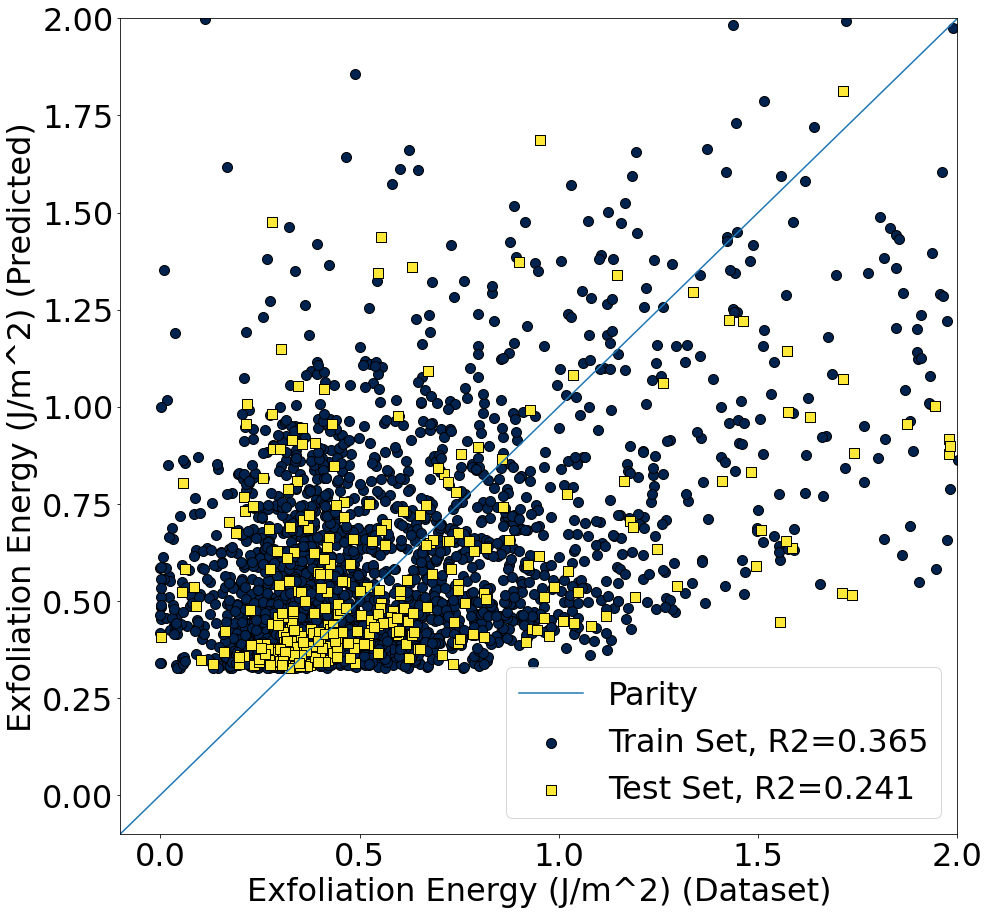

In [32]:
DigitalEcosystem.utils.figures.save_parity_plot_publication_quality(
                                    train_y_true = model.prop_train,
                                    train_y_pred =  model.fit,
                                    test_y_true = test_sisso["exfoliation_energy (J/m^2)"],
                                    test_y_pred = p_est,
                                    axis_label = "Exfoliation Energy (J/m^2)",
                                    axis_limits=[-0.1,2],
                                    filename = "sisso_2dm_exfoliation_parity_updated.jpeg")

# Original SISSO LASO Selection Results

In [20]:
sisso_feature_selector = sklearn.feature_selection.SelectFromModel(sklearn.linear_model.LassoCV(random_state=RANDOM_SEED),
                                                                   threshold=-np.inf,
                                                                   max_features=16,
                                                                   prefit=False)
sisso_feature_selector.fit(train_x, train_y.ravel())

sisso_features = [col for (col, is_selected) in zip(train[descriptors].columns, sisso_feature_selector.get_support()) if is_selected]
print("\n".join(sisso_features))

ave:Polarizability
ave:atomic_number
ave:atomic_radius
ave:atomic_radius_rahm
ave:atomic_volume
ave:atomic_weight
sum:boiling_point
sum:hhi_r
var:boiling_point
var:c6_gb
var:evaporation_heat
var:hhi_p
var:hhi_r
var:melting_point
var:sound_velocity
var:thermal_conductivity


In [149]:
sisso_dir = "./sisso"
os.makedirs(sisso_dir, exist_ok=True)

sisso_data_train = train[target_column + sisso_features]
sisso_data_test = test[target_column + sisso_features]

sisso_data_train.to_csv(os.path.join(sisso_dir, 'sisso_train.csv'), index_label='2dm_id (unitless)')

At this point, a SISSO model was run. The models are stored below.

The model forms are from the SISSO logfiles. For example, the "r1_1term" model corresponds with the 1-term model from rung 1.

The coefficients are extracted from the generated model `.dat` files, found in the `sisso/models` directory. 

In [150]:
sisso_models = {
    'r1_1term': lambda df: 1.137725259756883e+00 + \
                           -5.319007804268506e-02 * (df['ave:atomic_volume'] - df['ave:Polarizability']),
    
    'r1_2term': lambda df: -5.419391770626135e+00 + \
                           2.234184803571075e+01 * (df['ave:atomic_volume'] / df['ave:atomic_radius']) + \
                           3.806496811163907e-01 * (df['ave:atomic_radius'] / df['ave:atomic_volume']),
    
    'r1_3term': lambda df: -3.824902502678368e-01 + \
                           -1.407896279153107e-03 * (np.sqrt(df['var:evaporation_heat'])) + \
                           1.319703366669099e+01 * (1 / df['ave:atomic_volume']) + \
                           8.584309185950054e-01 * (df['ave:Polarizability'] / df['ave:atomic_volume']),
    
    'r1_4term': lambda df: -3.676480985399972e+00 + \
                           -1.203621743897748e-03 * (np.sqrt(df['var:evaporation_heat'])) + \
                           1.828431687132058e+01 * (df['ave:atomic_volume'] / df['ave:atomic_radius']) + \
                           2.977157680663882e-01 * (df['ave:atomic_radius'] / df['ave:atomic_volume']) + \
                           -3.507150688749609e-02 * (df['ave:atomic_volume'] - df['ave:Polarizability']),
    
    'r2_1term': lambda df: 3.424203469777740e-01 + \
                           1.061493336418310e+00 * ((df['ave:atomic_radius'] * df['ave:Polarizability']) / (df['ave:atomic_volume']**3)),
    
    'r2_2term': lambda df: 5.112510610979242e-01 + \
                           -1.116735994457529e-04 * ((df['ave:atomic_radius_rahm'] - df['ave:atomic_radius']) * (np.cbrt(df['var:evaporation_heat']))) + \
                           1.197095359098612e+00 * ((df['ave:atomic_radius'] * df['ave:Polarizability']) / (df['ave:atomic_volume']**3)),
    
    'r2_3term': lambda df: 5.078048028624726e-01 + \
                           1.081343713688761e+01 * ((np.sin(df['sum:hhi_r'])) / ((abs(df['var:hhi_p'] - df['ave:atomic_number'])))) + \
                           -1.111442185843957e-04 * ((df['ave:atomic_radius_rahm'] - df['ave:atomic_radius']) * (np.cbrt(df['var:evaporation_heat']))) + \
                           1.201332561215849e+00 * ((df['ave:atomic_radius'] * df['ave:Polarizability']) / (df['ave:atomic_volume'] ** 3)),
    
    'r2_4term': lambda df: -4.214956358883139e-02 + \
                           1.295753033325833e-15 * ((df['sum:boiling_point'] / df['sum:hhi_r']) * (df['ave:atomic_radius_rahm']**6)) + \
                           -1.271831240669525e+04 * ((np.exp(-1 * df['ave:atomic_number'])) / (df['var:hhi_p'] - df['ave:atomic_number'])) + \
                           -1.399766954307762e-04 * ((df['ave:atomic_radius_rahm'] - df['ave:atomic_radius']) * (np.cbrt(df['var:evaporation_heat']))) + \
                           8.874928783795299e+00 * ((df['ave:atomic_volume'] + df['ave:Polarizability']) / (df['ave:atomic_volume']**2))
}

for key, fun in sisso_models.items():
    print(f"==========\nSISSO Model {key}")
    sisso_train_predictions = fun(sisso_data_train)
    sisso_test_predictions = fun(sisso_data_test)
    sisso_data_train[key] = sisso_train_predictions
    sisso_data_test[key] = sisso_test_predictions
    
    print("\nTest Set Error Metrics")
    for metric, fun in metrics.items():
        value = fun(y_true=sisso_data_test['exfoliation_energy (J/m^2)'], y_pred=sisso_test_predictions)
        print(metric,np.round(value,4))

    print("\nTraining Set Error Metrics")
    for metric, fun in metrics.items():
        value = fun(y_true=sisso_data_train['exfoliation_energy (J/m^2)'], y_pred=sisso_train_predictions)
        print(metric,np.round(value,4))
    
    


SISSO Model r1_1term

Test Set Error Metrics
MaxError 2.0677
MAE 0.3102
MSE 0.1974
RMSE 0.4442
MAPE 4.0048
R2 0.1654

Training Set Error Metrics
MaxError 9.6349
MAE 0.311
MSE 0.2837
RMSE 0.5326
MAPE 5.0525
R2 0.1126
SISSO Model r1_2term

Test Set Error Metrics
MaxError 2.0505
MAE 0.2993
MSE 0.1918
RMSE 0.438
MAPE 3.4904
R2 0.1889

Training Set Error Metrics
MaxError 9.1049
MAE 0.3053
MSE 0.27
RMSE 0.5196
MAPE 5.2009
R2 0.1554
SISSO Model r1_3term

Test Set Error Metrics
MaxError 1.97
MAE 0.3041
MSE 0.1941
RMSE 0.4405
MAPE 3.7012
R2 0.1793

Training Set Error Metrics
MaxError 9.476
MAE 0.2904
MSE 0.2577
RMSE 0.5076
MAPE 5.2547
R2 0.1939
SISSO Model r1_4term

Test Set Error Metrics
MaxError 1.9744
MAE 0.2927
MSE 0.1839
RMSE 0.4288
MAPE 3.3222
R2 0.2224

Training Set Error Metrics
MaxError 9.1341
MAE 0.2873
MSE 0.2531
RMSE 0.5031
MAPE 5.1566
R2 0.2083
SISSO Model r2_1term

Test Set Error Metrics
MaxError 2.0307
MAE 0.2961
MSE 0.1768
RMSE 0.4204
MAPE 3.6368
R2 0.2525

Training Set Error Me

Finally, we'll go ahead and save the predictions of the SISSO model on the training and test set.

In [72]:
sisso_data_train.to_csv(os.path.join(sisso_dir, 'sisso_results_train.csv'))
sisso_data_test.to_csv(os.path.join(sisso_dir, 'sisso_results_test.csv'))

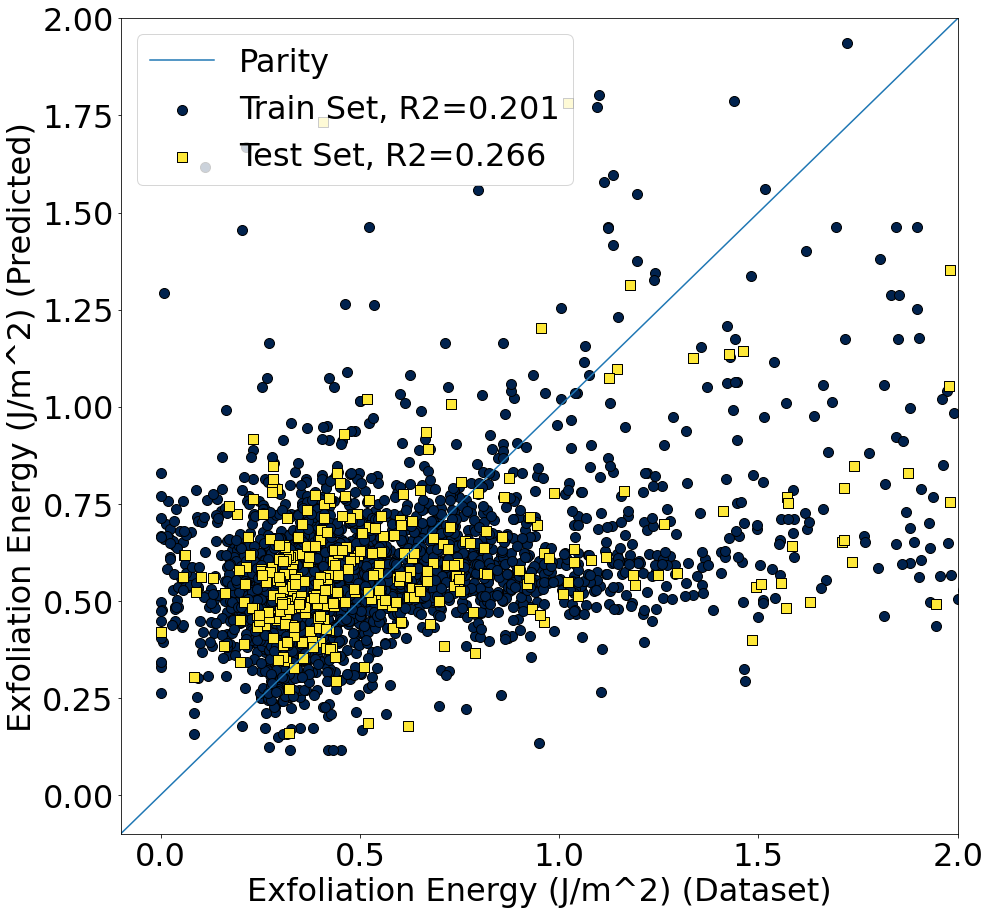

In [190]:
model_to_plot = 'r2_2term'
DigitalEcosystem.utils.figures.save_parity_plot_publication_quality(train_y_true = sisso_data_train['exfoliation_energy (J/m^2)'],
                                                                    train_y_pred = sisso_data_train[model_to_plot],
                                                                    test_y_true = sisso_data_test['exfoliation_energy (J/m^2)'],
                                                                    test_y_pred = sisso_data_test[model_to_plot],
                                                                    axis_label = "Exfoliation Energy (J/m^2)",
                                                                    axis_limits=[-0.1,2],
                                                                    filename = "sisso_2dm_exfoliation_parity.jpeg")

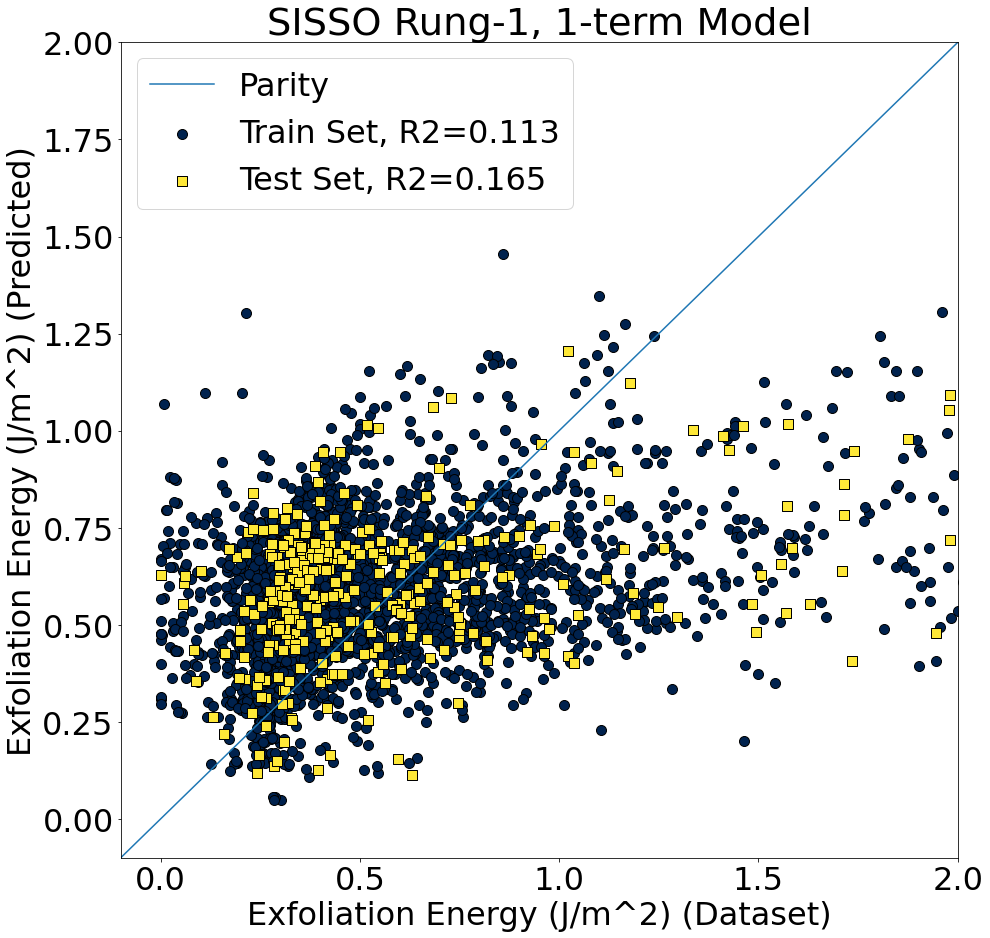

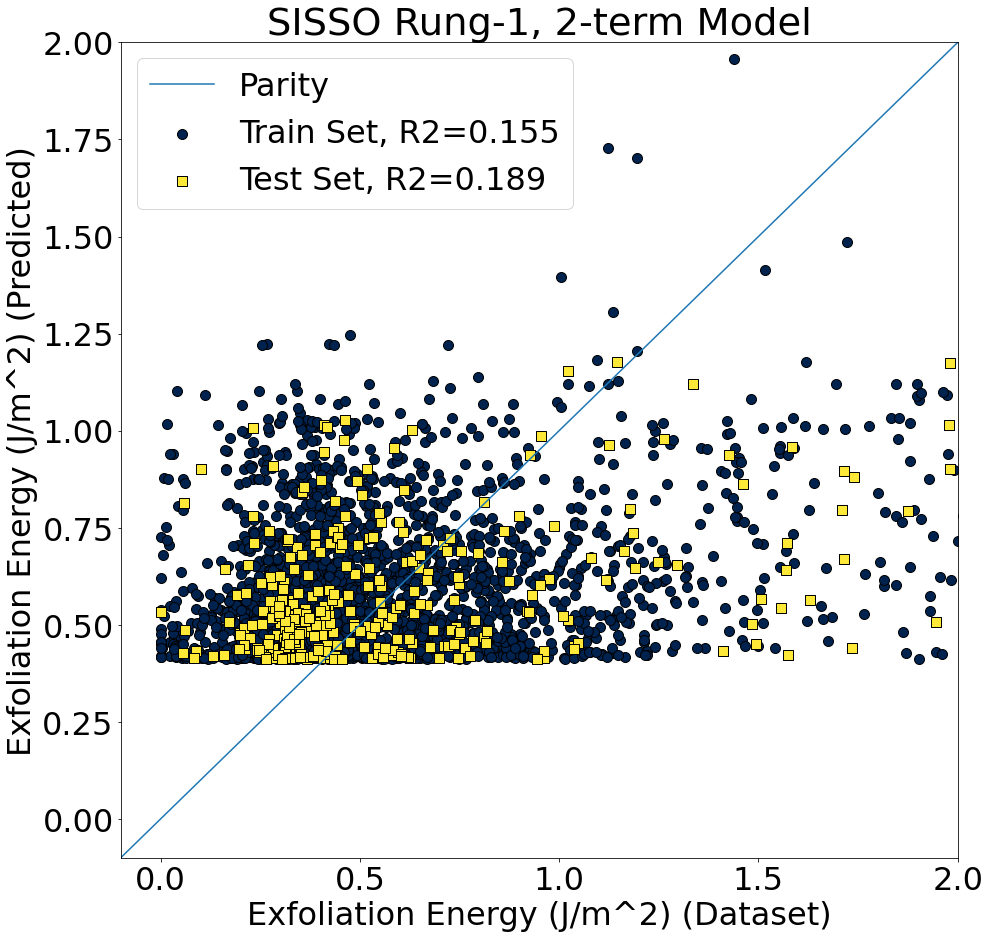

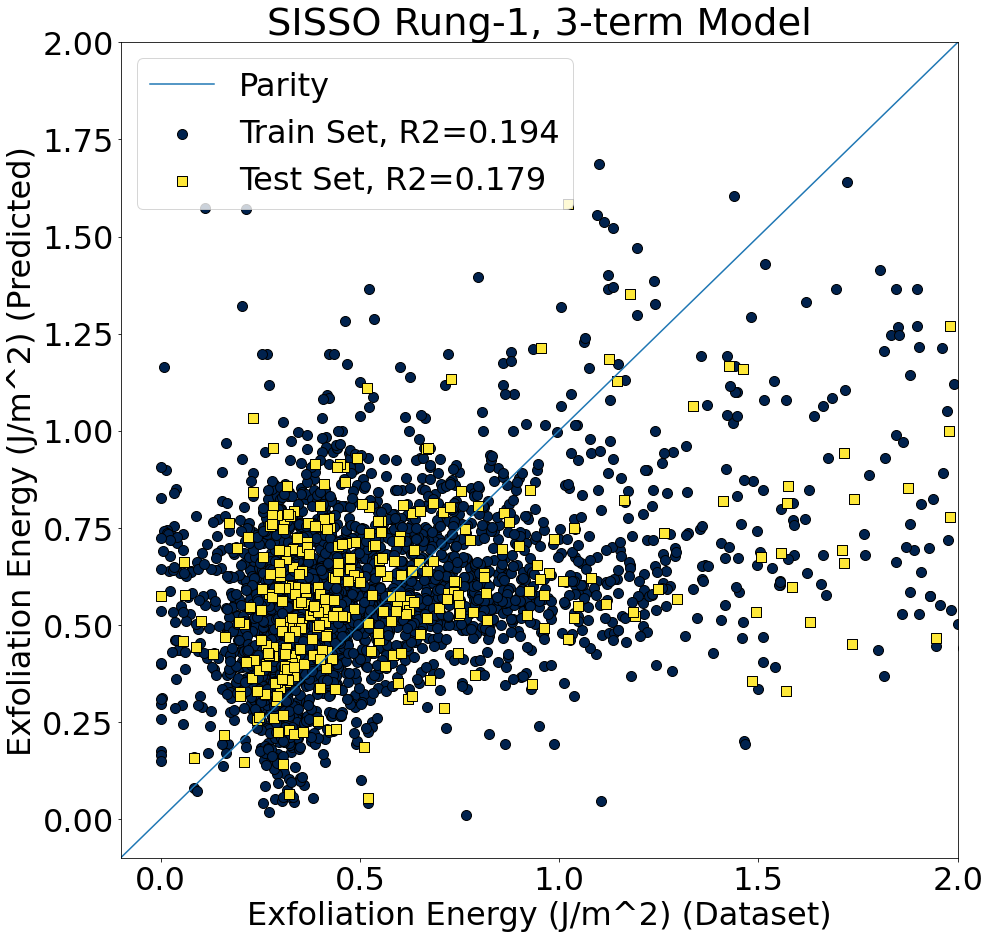

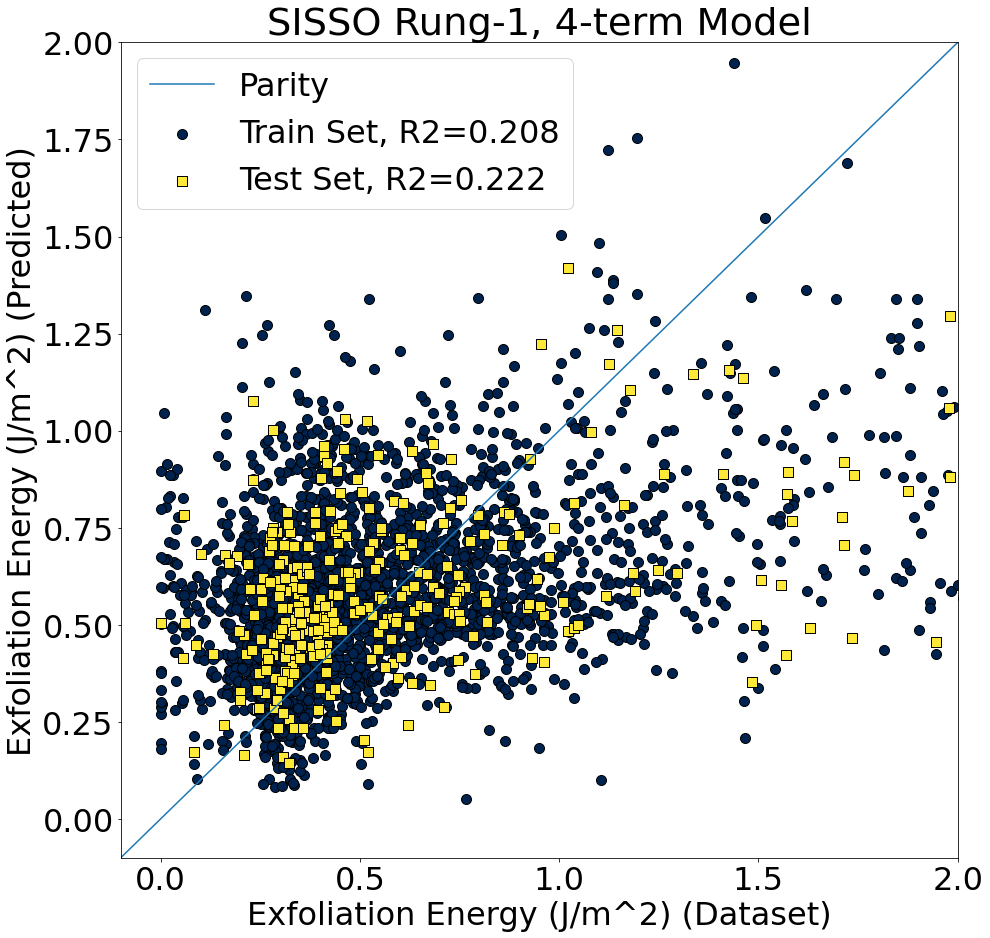

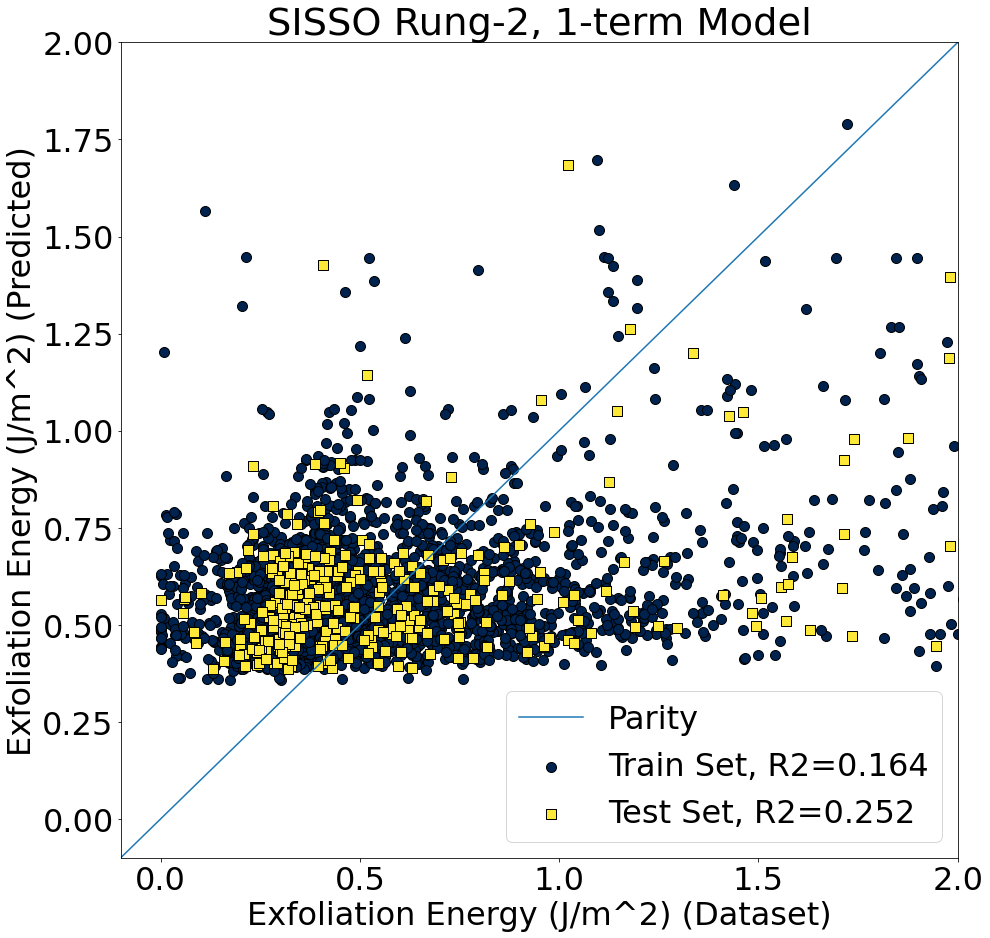

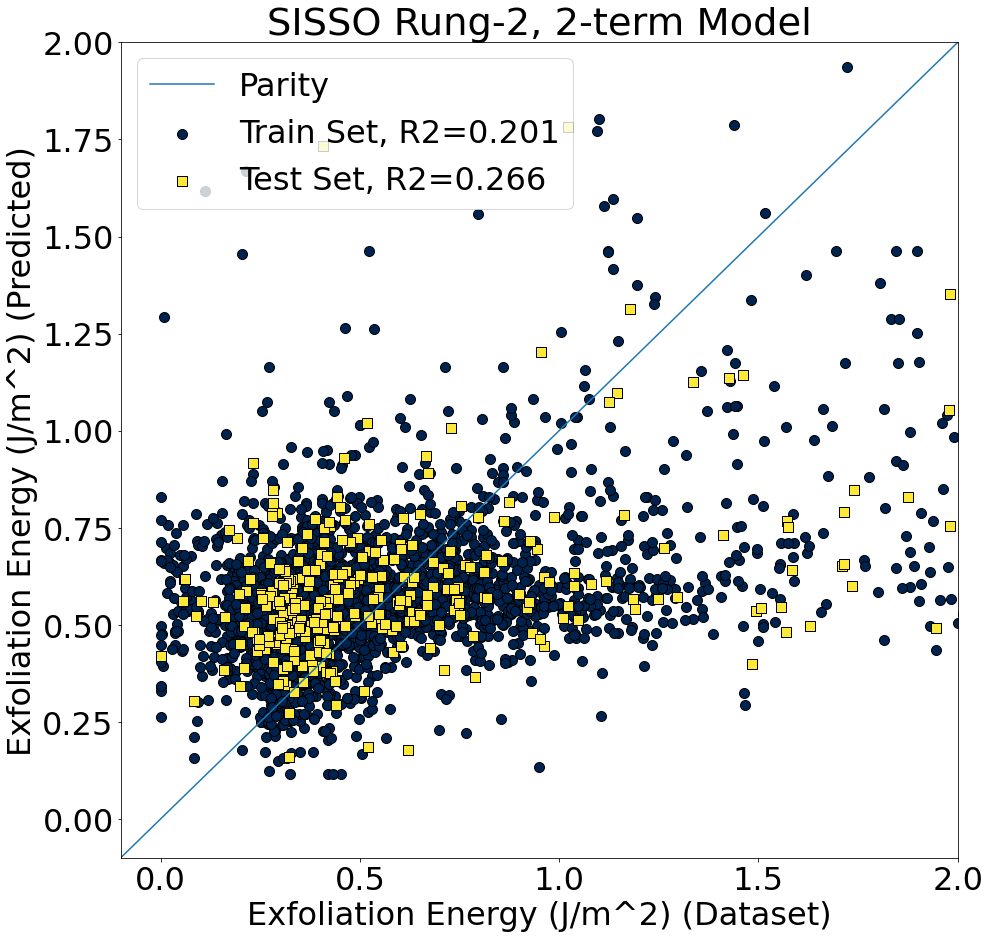

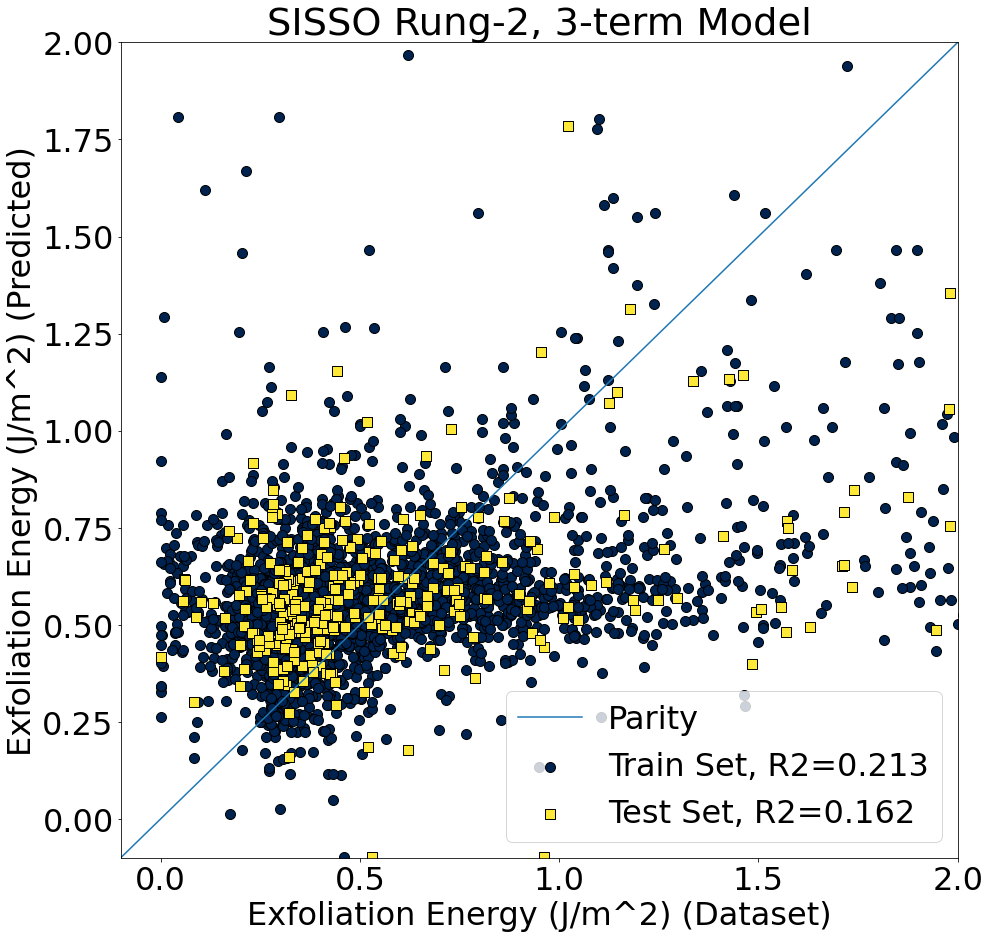

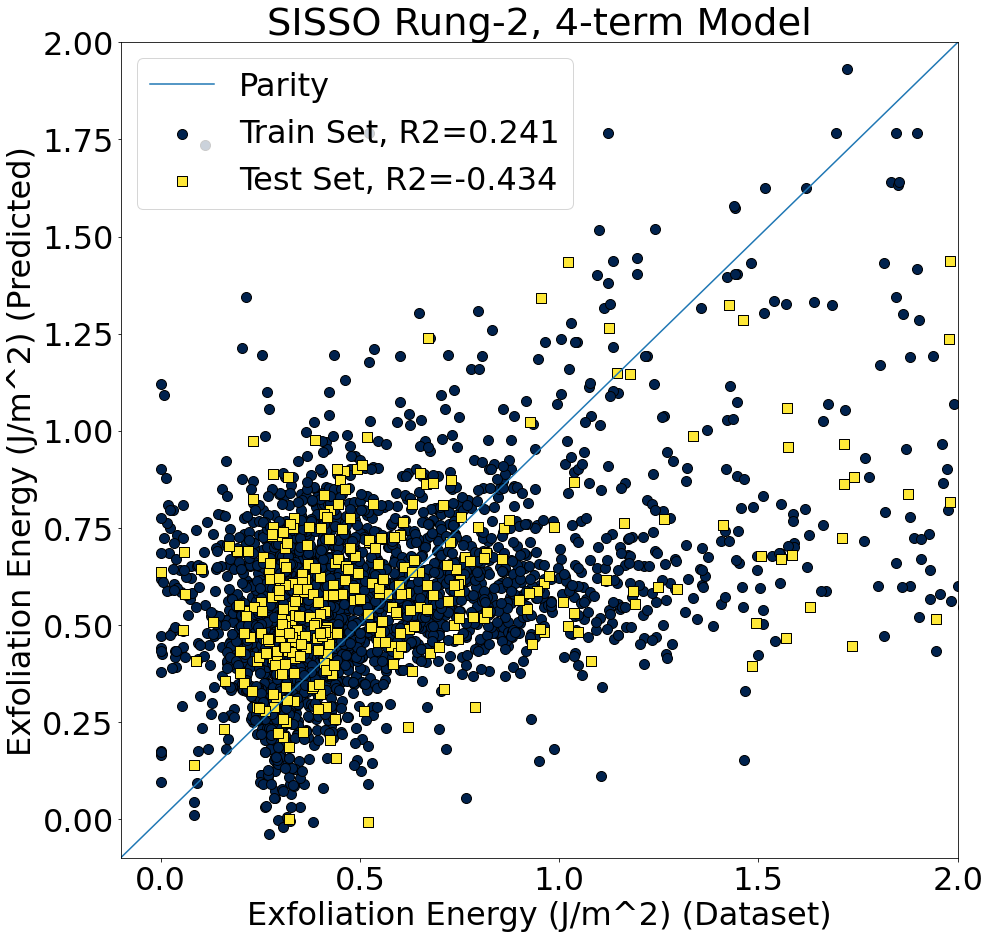

In [191]:
for model_to_plot in sisso_models.keys():
    DigitalEcosystem.utils.figures.save_parity_plot_publication_quality(train_y_true = sisso_data_train['exfoliation_energy (J/m^2)'],
                                                                        train_y_pred = sisso_data_train[model_to_plot],
                                                                        test_y_true = sisso_data_test['exfoliation_energy (J/m^2)'],
                                                                        test_y_pred = sisso_data_test[model_to_plot],
                                                                        axis_label = "Exfoliation Energy (J/m^2)",
                                                                        axis_limits=[-0.1,2],
                                                                        title=f'SISSO Rung-{model_to_plot[1]}, {model_to_plot[3]}-term Model')

In [163]:
extreme_outlier = data[['2dm_id (unitless)', 'atoms_object (unitless)', 'exfoliation_energy (J/m^2)']][data['exfoliation_energy (J/m^2)'] == data['exfoliation_energy (J/m^2)'].max()]['atoms_object (unitless)']
ase.io.write('common_outlier_2dm-5985.cif', extreme_outlier)

Turns out, the large outlier is a 2D layer of nitrogen atoms. Given that nitrogen has a strong energetic preference for being a gas phase diatomic system, this system would likely decompose to gaseous nitrogen if there were not the constraint on movement in the Z-direction. 2DMatPedia derived this structure from a Sb system (2dm-4275), itself obtained from a potentially exfoliable allotrope of Sb on Materials Project (mp-567509)

In [167]:
outlier_parent = data[['2dm_id (unitless)', 'atoms_object (unitless)']][data['2dm_id (unitless)'] == '2dm-4275']['atoms_object (unitless)']
ase.io.write('outlier_parent_2dm-4275.cif', outlier_parent)